## Load libraries and Data

In [1]:
DATA_DIR = './'

# -----------------------------------
# Test and train folder
# Data folder: drive > My Drive > Zindi-UmojaHackathon > data 
# -----------------------------------
TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

## Prerequisites

In [2]:
class LabelEncoder:
    def __init__(self, items) -> None:
        self.items = items
        self.size = int(len(self.items))
        self.items = {item:ix for ix,item in enumerate(self.items)}

    def __len__(self):
        return self.size

    def __call__(self, input):
        return self.encode(input)

    def encode(self, item):
        if item in self.items.keys():
            return int(self.items[item])  

        # self.OOV    
        return self.size

    def decode(self, ix):
        pass

In [3]:
import pandas as pd
import numpy as np

def pad_sequence(sequence: pd.DataFrame, encoder: LabelEncoder, pad_value: int=0):
    pad_list = sorted(set(range(0, len(encoder) + 1)).difference(set(sequence.sku_name.values)))
    pad_df = pd.DataFrame(pad_value, index=range(len(pad_list)), columns=sequence.columns)
    pad_df['sku_name'] = pad_list
    pad_df['month'] = sequence['month'].iloc[0].astype(int)
    pad_df['year'] = sequence['year'].iloc[0].astype(int)
    
    return pad_df

def pad_sku_sequence(features: pd.DataFrame, encoder:LabelEncoder, pad_value: int=0):
    features = features.groupby('sku_name').mean().reset_index()

    return features.append(pad_sequence(features, encoder, pad_value))

def pad_targets(targets: pd.DataFrame, target_series, pad_value: int=np.nan):
    missing = set(target_series).difference(set(targets[['month', 'year']].apply(tuple, axis=1).values))
    
    if missing:
        pad_df = pd.DataFrame(pad_value, index=range(len(missing)), columns=targets.columns)

        pad_df['sku_name'] = targets['sku_name'].values[0]
        pad_df['month'] , pad_df['year'] = zip(*missing)
        targets = targets.append(pad_df)

    return targets

In [4]:

def get_sequence_index(train: pd.DataFrame, n_steps: int, lookback:int):
    x_train_idx, y_train_idx = [], []
    x_val_idx, y_val_idx = [], []
    dates = sorted([(m, y) for y,m in train.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))
    size = train.groupby(['year', 'month']).ngroups//LOOKBACK
    
    for i in tqdm(range(size), desc='retrieving walk forward indices'):
        start = i*lookback
        train_ix = (i+1)*lookback
        val_ix = (i+2)*lookback
        

        x_train_date = dates[start:train_ix]
        y_train_date = dates[train_ix: train_ix+n_steps]

        x_val_date = dates[train_ix:val_ix]
        y_val_date = dates[val_ix: val_ix+n_steps]
        
        if val_ix+n_steps>train.groupby(['year', 'month']).ngroups:
            break
            
        x_train_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(x_train_date)].index)
        y_train_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(y_train_date)].index)

        x_val_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(x_val_date)].index)
        y_val_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(y_val_date)].index)
        
    return (x_train_idx, y_train_idx), (x_val_idx, y_val_idx)
 
def _pad_target(x,y, encoder: LabelEncoder):
    final_date = sorted([(m,yr) for yr,m in x[['year', 'month']].apply(tuple, axis=1)],\
                        key=lambda g: (g[1], g[0]), reverse=True)[0]
    
    target_dates = [(final_date[0]+n, final_date[1])\
                    if final_date[0]<12 else (final_date[0]-(12-1),final_date[1]+1)\
                    for n in range(1,N_STEPS+1)]
    
    y = y.groupby(['year', 'month']).apply(pad_sku_sequence, 
                                                    encoder=encoder, 
                                                    pad_value=np.nan).reset_index(drop=True)
    return y

def prepare_sequence(x_train: pd.DataFrame,
                     x_val: pd.DataFrame,
                     y_train: tuple,
                     y_val: tuple, 
                     encoder: LabelEncoder, 
                     target_cols: list,
                     step: int,
                     x_scaler,
                     y_scale):
 
    y_test = y_val.copy()
    x_train['sku_name'], x_val['sku_name'] = x_train['sku_name'].apply(encoder), x_val['sku_name'].apply(encoder) 
    y_train['sku_name'], y_val['sku_name'] = y_train['sku_name'].apply(encoder), y_val['sku_name'].apply(encoder) 

    # print(y_train, y_val)
    y_train = _pad_target(x_train, y_train, encoder)
    y_val = _pad_target(x_val, y_val, encoder)
    # print(y_train, y_val)
    x_train = x_train.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=encoder).reset_index(drop=True)
    x_val = x_val.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=encoder).reset_index(drop=True)
    
    # x_train = lag_shift(x_train, 'sku_name', channel_cols, [1,2,3])
    # x_val = lag_shift(x_val, 'sku_name', channel_cols, [1,2,3])

    # lag_cols = [c for c in x_train.columns if 'lag' in c]
    # x_train.loc[:, lag_cols] = x_train[lag_cols].fillna(0)
    # x_val.loc[:, lag_cols] = x_val[lag_cols].fillna(0)

    # y_train['sellin'] = y_train.groupby(['sku_name'])['sellin'].transform(lambda x: x.fillna(x.median()))
    # y_val['sellin'] = y_val.groupby(['sku_name'])['sellin'].transform(lambda x: x.fillna(x.median()))

    # y_train['sellin'] = y_train.groupby(['year', 'month'])['sellin'].transform(lambda x: x.fillna(x.median()))
    # y_val['sellin'] = y_val.groupby(['year', 'month'])['sellin'].transform(lambda x: x.fillna(x.median()))

    y_test['sku_name'] = y_test.sku_name.apply(encoder)
    y_test = y_test.sort_values(by=['sku_name','year','month'])[['sku_name','sellin','month','year']]
    
    # y_test['rule'], y_test['n_repeat'] = SEED, SEED
    y_test['idx'] = SEED
    y_test = y_test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)
    # x_train = x_train.groupby(['sku_name']).apply(_add_periodic_indices).reset_index(drop=True)
    # x_val = x_val.groupby(['sku_name']).apply(_add_periodic_indices).reset_index(drop=True)

    y_train = y_train.groupby(['sku_name','year','month']).mean().sort_values(by=['sku_name','year','month']).reset_index()
    y_val = y_val.groupby(['sku_name','year','month']).mean().sort_values(by=['sku_name','year','month']).reset_index()
    
    return (x_train.sort_values(by=['year','month','sku_name']).reset_index(drop=True), y_train[target_cols]), (x_val.sort_values(by=['year','month','sku_name']).reset_index(drop=True), y_val[target_cols]), y_test

  
def func(gp, name):
    dates = sorted([(m,y) for y,m in gp.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))
    gp = gp.sort_values(['year','month'])

    if len(gp)<N_STEPS:
        idx = [dates.index((date[1],date[0])) for date in gp[['year','month']].apply(tuple, axis=1)]
        # gp['rule'] = 0
        gp['idx'] = idx

        return gp

    if len(gp)==N_STEPS:
        # gp['rule'] = 1
        # gp['n_repeat'] = int(len(gp)/N_STEPS)
        # print(gp)
        gp['idx'] = list(range(N_STEPS))

        return gp

    for date in dates:
        idx = dates.index(date)
        # gp.at[(gp.month==date[0])&(gp.year==date[1]), 'rule'] = 2
        gp.loc[(gp.month==date[0])&(gp.year==date[1]), 'idx'] = idx
        # gp.at[(gp.month==date[0])&(gp.year==date[1]), 'n_repeat'] = len(gp[(gp.month==date[0])&(gp.year==date[1])])
    
    return gp

        

In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

def impute_missing(data):

    for d in tqdm(data, desc='imputing missing values'):
        d[0][1]['sellin'] = d[0][1].groupby(['sku_name'])['sellin'].transform(lambda x: x.fillna(x.median()))
        d[0][1]['sellin'] = d[0][1].groupby(['year', 'month'])['sellin'].transform(lambda x: x.fillna(x.median()))
      

def collate_fn(batch):
    x, y, y_test = [],[],[]
    # print(len(batch[0][0]))
    for xi, yi, yt in batch:
      # print(xi.shape)
      x.append(xi)
      y.append(yi)
      y_test.append(yt)

    return torch.stack(x), torch.stack(y), y_test

def prepare_data_scaler(x_scaler, y_scaler, target_scaler, train_data, val_data):
    x_df = pd.concat([d[0][0] for d in train_data+val_data], axis=0)
    y_df = pd.concat([d[0][1] for d in train_data+val_data], axis=0)
      
    x_scaler.fit(x_df.drop(columns=['sku_name']))
    y_scaler.fit(y_df.drop(columns=['sku_name']))
    target_scaler.fit(x_df['sellin'].values.reshape(-1,1))

    return x_scaler, y_scaler, target_scaler

def normalize_data(train_data: list, val_data:list, x_scaler, y_scaler):
    train_list, val_list = [], []

    for t,v in tqdm(zip(train_data,val_data), desc='normalizing data', total=len(train_data)): 
        xt, yt = t[0][0].copy(), t[0][1].copy()
        xv, yv = v[0][0].copy(), v[0][1].copy()
        x_cols = [c for c in xt.columns if 'sku_name' not in c]
        y_cols = [c for c in yt.columns if 'sku_name' not in c]

        xt[x_cols], yt[y_cols] = x_scaler.transform(xt[x_cols]), y_scaler.transform(yt[y_cols])
        xv[x_cols], yv[y_cols] = x_scaler.transform(xv[x_cols]), y_scaler.transform(yv[y_cols])

        train_list.append(((xt,yt),t[1]))
        val_list.append(((xv,yv),v[1]))

    return train_list, val_list

def get_data(train: pd.DataFrame, train_idx, val_idx, encoder: LabelEncoder, target_cols: list):
    train_list, val_list = [], []

    for ix in tqdm(range(len(train_idx[0])), desc='preparing sequences'):
        x_train, x_val = train.iloc[train_idx[0][ix]].reset_index(drop=True), train.iloc[val_idx[0][ix]].reset_index(drop=True)
        y_train, y_val = train.iloc[train_idx[1][ix]].reset_index(drop=True), train.iloc[val_idx[1][ix]].reset_index(drop=True)

        train_data, val_data, y_test = prepare_sequence(x_train, x_val, y_train, y_val, encoder, target_cols, ix, x_scaler, y_scaler)

        train_list.append((train_data, y_test))
        val_list.append((val_data, y_test))

    return train_list, val_list, [c for c in train_data[0].columns if c not in ['sku_name','year','month']]


# class FossilDataset(Dataset):
#     def __init__(self, 
#                  features,
#                  targets,
#                  y_test,
#                  encoder:LabelEncoder):
      
#         self.features = features
#         self.targets = targets
#         self.y_test = y_test
#         self.encoder = encoder


#     def __len__(self):
#         return 1#len(self.features)

#     def __getitem__(self, idx):
#         # (self.features, self.targets), y_test = self.data[idx]
        
#         return torch.as_tensor(self.features), torch.as_tensor(self.targets).squeeze(), self.y_test


class FossilDataset(Dataset):
    def __init__(self, 
                 data: list, 
                 encoder:LabelEncoder,
                 training: bool=True):
      
        self.data = data
        self.encoder = encoder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (self.features, self.targets), y_test = self.data[idx]
        
        feat_group = self.features.sort_values(['sku_name','year','month']).groupby(['month','year'])

        seq = np.array([v.drop(columns=['sku_name','year','month']) for k,v in feat_group]) #(timesteps, products, features)
        seq = np.transpose(seq, (2,0,1)) #(features, timesteps, products)
        
        targets = self.targets.sort_values(['sku_name','year','month'])
        targets = targets.drop(columns=['month', 'year', 'sku_name']).values #(timesteps*products, target)

        return torch.as_tensor(seq), torch.as_tensor(targets).squeeze(), y_test

    


In [6]:
import torch
import torch.nn as nn

class FossilModel(nn.Module):
    def __init__(self, 
                 n_features: int, 
                 n_extracts: int,
                 n_products: int,
                 n_steps: int):
        super(FossilModel, self).__init__()

        self.monthly_conv2d = nn.Conv2d(n_features, n_extracts, (1,1))
        self.periodic_conv2d = nn.Conv2d(n_extracts, n_extracts, (1, n_products))
        self.max_pool2d = nn.MaxPool2d((2,1))

        self.conv2d = nn.Conv2d(n_extracts, n_extracts, (1,1))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(n_extracts*LOOKBACK, n_steps*7)
        self.fc2 = nn.Linear(n_steps*7, n_steps*n_products)

    def forward(self, x):
        x = self.monthly_conv2d(x)
        x = self.relu(x)
        

        x = self.periodic_conv2d(x)
        x = self.relu(x)
        
        # x = self.max_pool2d(x)
        

        # x = self.conv2d(x)
        # x = self.relu(x)
        
        # x = self.max_pool2d(x)
        # print(x.shape)
        x = x.view(x.size(0),-1)
        
        out = self.fc1(self.dropout(x))
        out = self.relu(out)
        
        return self.fc2(out)

In [7]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import re
import time
import random
import numpy as np
from time import time
from pathlib import Path
        
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

class ModelTrainer:
    def train_model(self, early_stop=3, verbose=10, save_path=None):
        
        stop_eps = 0 
        best_epoch = None
        metrics = {'MAE':[]}
        start_time = time()
        accum_loss = torch.tensor(float('inf')) if not self.resume_train else torch.tensor(float(re.findall("\d+\.\d+", self.model_weights)[0]))
        try:
            for epoch in range(1, ModelsConfig.EPOCHS + 1):
                train_loss = self.train_step(epoch, verbose)             
                test_loss, w8, mae = self.val_step(epoch)

                if test_loss < accum_loss:
                    best_epoch = epoch
                    accum_loss = test_loss

                    self.model_checkpoints.append((w8, test_loss, mae))
                    stop_eps = 0
                else:
                    stop_eps += 1
                if epoch % verbose ==0:
                    print('Epoch {}: Train Loss: {:.4f}\tVal Loss: {:.4f}\tVal MAE: {:.2f}\telapsed: {:.2f} mins'.format(
                    epoch, torch.mean(train_loss), test_loss, mae, (time()-start_time)/60))
                

                if stop_eps >= early_stop:
                    self.save_model_checkpoint(save_path)
                    print('\n')
                    print('Early stopping: Best Epoch: {}\tVal loss: {:.4f}\tVal MAE: {:.2f}\tTotal time elapsed: {:.2f} mins'.format(
                        best_epoch, accum_loss, mae, (time()-start_time)/60))
                    print('-'*50)
                    print('\n')
                    break

        except KeyboardInterrupt:
            self.save_model_checkpoint(save_path) if self.model_checkpoints else print("first epoch not completed, model checkpoint will not be saved")
            
            if stop_eps<early_stop:
                print(f'Training stopped, early stop not reached. Best Iteration: {best_epoch} Val loss: {accum_loss} Val MAE: {mae}')

    def save_model_checkpoint(self, save_path):
        best_model, accum_loss, metrics = self.model_checkpoints[-1]

        if save_path is not None:
            torch.save(best_model, Path(save_path).joinpath(f'loss_{accum_loss}_MAE_{metrics}_fossil.pth'))

    def load_model_checkpoint(self, save_path):
        self.model.load_state_dict(torch.load(Path(save_path)))            

class Pipeline(ModelTrainer):
    def __init__(self, train_dataloader, test_dataloader, model, target_scaler, resume_from_checkpoint=False, model_weights=None):
        
        self.model = model.to(ModelsConfig.device) 
        self.resume_train = resume_from_checkpoint
        self.model_weights = model_weights
        self.target_scaler = target_scaler

        if self.resume_train:
            assert model_weights is not None, "specify model weights save location"
            self.load_model_checkpoint(self.model_weights)

        self.train_loader = train_dataloader
        self.test_loader = test_dataloader

        self.criterion = nn.L1Loss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=ModelsConfig.learning_rate)
        
        self.model_checkpoints = []

    def train_step(self, epoch, verbose):
        self.model.train()
        
        train_loss=[]
        start_time = time()
        data_len = len(self.train_loader.dataset)

        for batch_idx, (inputs,labels, y_) in enumerate(self.train_loader):
            inputs = inputs.to(ModelsConfig.device)
            labels = labels.to(ModelsConfig.device)

            self.optimizer.zero_grad()
            preds = self.model(inputs)
            
            # na_idx = list(labels.isnan().nonzero().transpose(0,1))
            # labels[na_idx] = preds[na_idx]

            loss = self.criterion(preds,labels)
            loss.backward()

            self.optimizer.step()
            train_loss.append(loss.item())
        return loss
            # if batch_idx % verbose == 0 or batch_idx == len(self.train_loader)-1:
                # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\telapsed: {:.2f} mins'.format(
                #     epoch, batch_idx * len(inputs), data_len, 100. * batch_idx / len(self.train_loader), loss.item(), (time()-start_time)/60))
                
    def val_step(self, epoch):
        # print('\nevaluating…')
        self.model.eval()
        test_loss = 0
        mae = 0
        with torch.no_grad():
            for batch_idx, (inputs, labels, y_) in enumerate(self.test_loader):
                if batch_idx==(len(self.test_loader)-1):
                    inputs = inputs.to(ModelsConfig.device)
                    labels = labels.to(ModelsConfig.device)

                    self.optimizer.zero_grad()

                    preds = self.model(inputs)
                    # na_idx = list(labels.isnan().nonzero().transpose(0,1))
                    # labels[na_idx] = preds[na_idx]

                    loss = self.criterion(preds,labels)

                    test_loss += loss.item()# / len(self.test_loader)
                    mae += self.eval_step(y_, preds)# / len(self.test_loader)

        # print('Test set: Average loss: {:.4f} | MAE: {:.4f}\n'.format(test_loss, mae))

        return round(test_loss, 4), self.model.state_dict(), mae

    def eval_step(self, labels: list, preds):
        mae = 0
        preds = preds.cpu().detach().numpy().reshape(len(labels), -1)
        
        # pandarallel.initialize(use_memory_fs=False)

        for i,label in enumerate(labels):
            label['y_true'] = label['sellin'].copy()
            label['y_pred'] = preds[i].reshape(-1, N_STEPS)[label.sku_name.values, label.idx.values]
            # print(label)
            # label = label.groupby('sku_name').apply(lambda x: self.func(x, x.name, preds[i].reshape(-1, N_STEPS))).reset_index(drop=True)
            # print(label[label.sku_name==len(sku_encoder)])

            # assert False
            y_true = label['y_true'].values.reshape(1, -1)
            y_pred = self.target_scaler.inverse_transform(label['y_pred'].values.reshape(1, -1))
            label['y_pred'] = y_pred.reshape(-1,)
            mae += np.absolute(np.subtract(y_true, y_pred)).mean()/len(labels)

        return mae

    def func(self, gp, name, preds):
        dates = sorted([(m,y) for y,m in gp.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))
        gp = gp.sort_values(['year','month'])

        if len(gp)<N_STEPS:
            idx = [dates.index((date[1],date[0])) for date in gp[['year','month']].apply(tuple, axis=1)]
            gp['sellin'] = preds[name, :len(gp)]

            return gp

        if len(gp)%N_STEPS==0:
            gp['sellin'] = np.tile(preds[name, :], int(len(gp)/N_STEPS))

            return gp

        for date in dates:
            idx = dates.index(date)
            gp.loc[(gp.month==date[0])&(gp.year==date[1]), 'sellin'] = np.tile(preds[name, idx], len(gp[(gp.month==date[0])&(gp.year==date[1])]))
        
        return gp

    def make_oof_preds(self):
        self.model.eval()
        with torch.no_grad():
            for batch_idx, (inputs, labels, y_) in enumerate(self.test_loader):
                if batch_idx==(len(self.test_loader)-1):
                    inputs = inputs.to(ModelsConfig.device)
                    labels = labels.to(ModelsConfig.device)

                    self.optimizer.zero_grad()
                    return self.model(inputs)

In [8]:
def prepare_test_data(train: pd.DataFrame, test_dates:list, x_scaler=None):
    test_context = train[train[['month','year']].apply(tuple, axis=1).isin(test_dates)].reset_index(drop=True)
    scale_cols = [c for c in test_context.columns if 'sku_name' not in c]

    test_context['sku_name'] = test_context['sku_name'].apply(sku_encoder)
    test_context = test_context.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)
    test_context[scale_cols] = x_scaler.transform(test_context[scale_cols])

    test_gp = test_context.sort_values(['sku_name','year','month']).groupby(['month','year'])
    test_seq = np.array([v.drop(columns=['sku_name','year','month']) for k,v in test_gp])

    return np.transpose(test_seq, (2,0,1))

def merge_func(gp, name, pred_array):
    gp = gp.sort_values(['year','month'])
    gp['sellin'] = np.tile(pred_array[name, :], int(len(gp)/N_STEPS))
    
    return gp

def make_predictions(seq: np.array, model: FossilModel, test_df: pd.DataFrame):
    preds = model(torch.as_tensor(seq).unsqueeze(0).to(ModelsConfig.device))
    pred_arr = preds.detach().numpy().reshape(-1, N_STEPS)
    test_df['sellin'] = pred_arr[test_df.sku_coded.values, test_df.idx.values]
    
    return test_df.copy()

def make_submission(predictions: pd.DataFrame, dates: list, target_scaler):
    predictions['Target'] = predictions['sellin']
    predictions['Item_ID'] = predictions['sku_name'].astype(str)+'_'+predictions['month'].astype(str)+'_'+predictions['year'].astype(str)
    predictions['Target'] = target_scaler.inverse_transform(predictions['Target'].values.reshape(-1,1))
    
    date_id = [f'{m}_{y}' for m,y in dates]
    sub = pd.DataFrame(predictions.sort_values('sku_name', ascending=False).sku_name.astype(str)+'_'+date_id*predictions.sku_name.nunique())
    sub = sub.reset_index(drop=True).rename(columns={'sku_name':'Item_ID'})
    
    return sub.merge(predictions[['Item_ID', 'Target']])

In [9]:

def cyclic_encode(df: pd.DataFrame, columns: list):
    """
    """
    
    for col in columns:
        max_val = df[col].max()

        df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
        
    return df

In [10]:

def _add_periodic_indices(df: pd.DataFrame):
    """
    
    
    """
    df = df.sort_values(['year','month'])
    # get indices of observations from each product
    df['idx'] = df.groupby('sku_name').cumcount()

    df['annual_idx'] = df['idx'] % 12     
    df['9month_idx'] = df['idx'] % 9 
    df['semi_annual_idx'] = df['idx'] % 6 
    df['quarterly_idx'] = df['idx'] % 3 
    df['2month_idx'] = df['idx'] % 2 

    return df

In [11]:
def lag_shift(df: pd.DataFrame, 
              group_by_col_name: str, 
              features: list, 
              lag_shift_periods: list):

        """
        """
        df = df.sort_values(by=['year','month'])

        for lp in lag_shift_periods:
            for feat in features:
                forward = f'{lp}month_fwd_lag_{feat}'
                backward = f'{lp}month_bwd_lag_{feat}'
                forw_diff, back_diff = f'{forward}_diff', f'{backward}_diff'

                group = df.groupby(group_by_col_name)[feat]

                # Perform forward lag shift
                df[forward] = group.shift(lp)

                # Perform backwards lag shift
                # df[backward] = group.shift(-lp)

                # Shift difference
                df[forw_diff] = df[feat] - df[forward]
                # df[back_diff] = df[backward] - df[feat]

        return df

## Preprocessing

In [23]:
SEED = 1121
N_STEPS = 4
LOOKBACK = 3
random.seed(SEED)

In [24]:

class ModelsConfig():

    # setting random seed
    torch.manual_seed(SEED)

    # checks if gpu is available
    use_cuda = torch.cuda.is_available() 
    device = torch.device("cuda:0" if use_cuda else "cpu")
    learning_rate = 1e-2

    EPOCHS = 100000

class DataConfig():
    dataloader_params = dict(        
    batch_size=3,
    collate_fn= lambda x: collate_fn(x),
    shuffle=False,
    # num_workers=2, 
    # pin_memory=True
    )


In [25]:
import pandas as pd
import random

train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

CAT = desc[36:]['Column Name'].tolist()
channel_cols = [c for c in train.columns if any(f'_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name']]
train_df = train.drop(columns=CAT)

In [26]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# train_df = cyclic_encode(train_df, ['month'])
# train_df = lag_shift(train_df, 'sku_name', channel_cols, [3,6,9])

In [27]:
dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))
final_date = dates[-1]
xtra = [(final_date[0]+i,final_date[1]) if final_date[0]+i<=12 else (final_date[0]+i-12, final_date[1]+1) for i in range(1,N_STEPS+1)]

In [28]:
xtra_df = pd.DataFrame(np.nan, index=range(train_df.sku_name.nunique()), columns=train_df.columns)
xtra_df['sku_name'] = train_df.sku_name.unique()
xtra_rep = pd.DataFrame(np.repeat(xtra_df.values, N_STEPS, axis=0), columns=train_df.columns)

In [29]:
def assign_dates(gp, dates):
    gp['month'],gp['year'] = zip(*dates)
    return gp

In [30]:
train_df = pd.concat([train_df, xtra_rep.groupby('sku_name').apply(assign_dates, xtra)]).reset_index(drop=True)
train_df[[c for c in train_df.columns if 'sku_name' not in c]] = train_df.groupby(['sku_name']).transform(lambda x: x.fillna(x.median()))

In [31]:
# train_df = lag_shift(train_df, 'sku_name', channel_cols, [3, 6, 9])

# lag_cols = [c for c in train_df.columns if 'lag' in c]
# train_df.loc[:, lag_cols] = train_df[lag_cols].fillna(0)

In [32]:
train_df = train_df.sort_index()

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
    
target_cols = ['sku_name', 'sellin', 'month', 'year']

train_idx, val_idx = get_sequence_index(train_df, N_STEPS, LOOKBACK)
train_data, val_data, features = get_data(train_df, train_idx, val_idx, sku_encoder, target_cols)

retrieving walk forward indices:   0%|          | 0/20 [00:00<?, ?it/s]

preparing sequences:   0%|          | 0/18 [00:00<?, ?it/s]

In [34]:

impute_missing(train_data)
impute_missing(val_data)

x_scaler, y_scaler, target_scaler = prepare_data_scaler(x_scaler, y_scaler, target_scaler, train_data, val_data)
train_norm, val_norm = normalize_data(train_data, val_data, x_scaler, y_scaler)

imputing missing values:   0%|          | 0/18 [00:00<?, ?it/s]

imputing missing values:   0%|          | 0/18 [00:00<?, ?it/s]

normalizing data:   0%|          | 0/18 [00:00<?, ?it/s]

## Walk Forward Training and Validation

In [40]:
from torch.utils.data import DataLoader

window = 3
expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_norm)):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
        val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
        
    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 1.0/2016.0 to 1.0/2016.0:


Epoch 5: Train Loss: 0.1717	Val Loss: 0.0754	Val MAE: 902977.76	elapsed: 0.00 mins
Epoch 10: Train Loss: 0.0445	Val Loss: 0.0394	Val MAE: 499224.89	elapsed: 0.00 mins
Epoch 15: Train Loss: 0.0242	Val Loss: 0.0235	Val MAE: 313471.05	elapsed: 0.01 mins
Epoch 20: Train Loss: 0.0148	Val Loss: 0.0157	Val MAE: 228934.70	elapsed: 0.01 mins
Epoch 25: Train Loss: 0.0106	Val Loss: 0.0120	Val MAE: 189800.88	elapsed: 0.01 mins
Epoch 30: Train Loss: 0.0078	Val Loss: 0.0096	Val MAE: 167073.30	elapsed: 0.01 mins
Epoch 35: Train Loss: 0.0057	Val Loss: 0.0079	Val MAE: 148917.34	elapsed: 0.01 mins
Epoch 40: Train Loss: 0.0045	Val Loss: 0.0069	Val MAE: 141036.39	elapsed: 0.01 mins
Epoch 45: Train Loss: 0.0036	Val Loss: 0.0061	Val MAE: 133376.22	elapsed: 0.02 mins
Epoch 50: Train Loss: 0.0031	Val Loss: 0.0057	Val MAE: 129322.30	elapsed: 0.02 mins
Epoch 55: Train Loss: 0.0028	Val Loss: 0.0054	Val MAE: 126493.76	elapsed: 0.02 mins
Epoch 60: Train Loss: 0.0026

In [26]:
from torch.utils.data import DataLoader

window = 3
expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_norm)):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
        val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
        
    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 1/2016 to 1/2016:


Epoch 5: Train Loss: 0.0557	Val Loss: 0.0498	Val MAE: 613588.91	elapsed: 0.00 mins
Epoch 10: Train Loss: 0.0246	Val Loss: 0.0228	Val MAE: 304233.63	elapsed: 0.00 mins
Epoch 15: Train Loss: 0.0152	Val Loss: 0.0163	Val MAE: 232219.72	elapsed: 0.01 mins
Epoch 20: Train Loss: 0.0110	Val Loss: 0.0121	Val MAE: 192194.17	elapsed: 0.01 mins
Epoch 25: Train Loss: 0.0074	Val Loss: 0.0094	Val MAE: 161688.08	elapsed: 0.01 mins
Epoch 30: Train Loss: 0.0057	Val Loss: 0.0077	Val MAE: 147008.15	elapsed: 0.01 mins
Epoch 35: Train Loss: 0.0044	Val Loss: 0.0067	Val MAE: 138624.88	elapsed: 0.01 mins
Epoch 40: Train Loss: 0.0035	Val Loss: 0.0060	Val MAE: 131620.00	elapsed: 0.01 mins
Epoch 45: Train Loss: 0.0030	Val Loss: 0.0056	Val MAE: 128517.42	elapsed: 0.02 mins
Epoch 50: Train Loss: 0.0026	Val Loss: 0.0053	Val MAE: 125553.37	elapsed: 0.02 mins
Epoch 55: Train Loss: 0.0024	Val Loss: 0.0051	Val MAE: 123680.08	elapsed: 0.02 mins
Epoch 60: Train Loss: 0.0023	Val Los

## Prepare OOF

In [55]:
def prepare_cnn_oof(model, train_norm, val_norm):
    
    oof_list, train_set, val_set = [], [], []
    pred_cols = [f'y_pred_{j+1}' for j in range(N_STEPS)]

    for ix in tqdm(range(len(train_norm)), desc='creating OOF predictions'):
        if expanding_window:
            train_set += [train_norm[ix]]
            val_set += [val_norm[ix]]
            
        else:
            train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
            val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]

        train_dataset = FossilDataset(train_set, sku_encoder)
        val_dataset = FossilDataset(val_set, sku_encoder, False)

        train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
        valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)

        # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()

        pipe = Pipeline(train_loader, valid_loader, model, target_scaler)
        pipe.model.load_state_dict(models[ix])

        oof_preds = pipe.make_oof_preds()
        oof_preds = target_scaler.inverse_transform(oof_preds.reshape(1, -1)).reshape(-1, N_STEPS)# (products, preds)
        oof_list.append(pd.DataFrame(oof_preds, columns=pred_cols))
        
    return oof_list

def update_data(oof, train_data, val_data):
    pred_cols = [f'y_pred_{j+1}' for j in range(N_STEPS)]
    train_list, val_list = [], []
    
    for ix in tqdm(range(len(train_data)), desc='updating training data with OOF predictions'):
        x_val = val_data[ix][0][0].join(oof[ix])
        
        if ix==len(train_data)-1:
            val_list.append(((x_val,val_data[ix][0][1]),val_data[ix][1]))
            continue

        if ix==0:
            train_data[ix][0][0][pred_cols] = np.nan
            x_train = train_data[ix][0][0].copy()
        else:
            x_train = train_data[ix][0][0].join(oof[ix-1])
            
        train_list.append(((x_train,train_data[ix][0][1]),train_data[ix][1]))
        val_list.append(((x_val,val_data[ix][0][1]),val_data[ix][1]))

    return train_list, val_list


In [56]:
model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
oof_list = prepare_cnn_oof(model, train_norm, val_norm)
train_data, val_data = update_data(oof_list, train_data, val_data)

creating OOF predictions:   0%|          | 0/57 [00:00<?, ?it/s]

updating training data with OOF predictions:   0%|          | 0/57 [00:00<?, ?it/s]

## LightGBM

In [35]:
from time import time
import lightgbm as lgb 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [36]:
#function to make feature-importance plot
def plot_Imp_lgb(model, X, score):
    '''
    A funtion to make feature importance plot for LGBM.
    Returns feature-impotance plot.

    args: model -trained model
    args: X     - features used to train model
    
    '''
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(f'./lgbm_importances{score}.png')
    plt.show()

In [37]:
def update_feature_importances(x_train, model, fold, feature_importance):
    # feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = x_train.columns
    fold_importance["importance"] = model.feature_importance()
    fold_importance["fold"] = fold + 1
    
    return pd.concat([feature_importance, fold_importance], axis=0)

def cv_feature_importance_plot(train_data: list, val_data: list, folds: int, cv_models: list, plot_feature_importance: bool=True):

    size = len(train_data)//folds
    feature_importance = pd.DataFrame()
    
    for fold in range(folds):
        # print(f'Training fold {fold+1}')
        print('\n')
        train_set = train_data[fold*size:(fold+1)*size]
        val_set = val_data[fold*size:(fold+1)*size]

        x_train, y_train, x_val, y_val, test = prepare_fold_data(train_set, val_set)
        models = cv_models[fold]
        
        for i,model in enumerate(models):
            feature_importance = update_feature_importances(x_train.drop(columns=['sku_name']), model, fold, feature_importance)
            if plot_feature_importance:
                plot_Imp_lgb(model, x_train.drop(columns=['sku_name']), f'fold_{fold}_step_{i}')

    return feature_importance

In [38]:
from copy import copy

def evaluate(df, oof, target_col):    
    df_out = df.copy()
    df_out['oof'] = oof
    oof_mae = np.absolute(np.subtract(df_out[target_col], df_out['oof'])).mean()
    
    return oof_mae

In [39]:
def eval_step(df, oof, target_col):    
    metrics = evaluate(df, oof, target_col)
    print(f'OOF MAE: %.4F'%metrics)
    gc.collect()
    

In [40]:
def cv_train(params, xy_train, xy_val): 
    train_set = lgb.Dataset(*xy_train)
    val_set = lgb.Dataset(*xy_val)

    # train model
    return lgb.train(params, 
                    train_set,
                    num_boost_round = 100000,
                    callbacks=[lgb.early_stopping(stopping_rounds=5),lgb.log_evaluation(period=5000)],
#                     early_stopping_rounds = 5, 
                    valid_sets = [train_set, val_set], 
#                     verbose_eval = 1000
                    )

In [41]:
def test_model(train_data, val_data, folds, cv_models):
    start_time = time()
    size = len(train_data)//folds
    mae = []

    for fold in range(folds):
        train_set = train_data[fold*size:(fold+1)*size]
        val_set = val_data[fold*size:(fold+1)*size]

        x_train, y_train, x_val, y_val, test = prepare_fold_data(train_set, val_set)
        x_test = x_val[x_val.sku_name.isin(test.sku_name.unique())]

        print(f"Making fold {fold+1} predictions")
        # predict oof
        oof_preds = np.concatenate(multi_step_test(x_test, cv_models[fold])).reshape(-1, N_STEPS)[test.sku_name.values, test.idx.values]
        
        mae.append(evaluate(test, oof_preds, 'sellin'))
        print("valid MAE {:.4f}\tElapsed {:.2f} mins".format(mae[-1], (time() - start_time)/60))
        print('-'*50)
        print('\n')

    val_mae = np.mean(mae)
    print(f'Average Val MAE: {val_mae}')
    del(x_test)
    gc.collect()
    
    return val_mae

In [42]:
def prepare_fold_data(train_set, val_set):
    x_t, y_t, x_v, y_v, te = [], [], [], [], []
    for t,v in zip(train_set, val_set):
        x_t.append(t[0][0])
        x_v.append(v[0][0])
        te.append(v[1])

        t[0][1]['target'] = 'target_'+t[0][1].groupby('sku_name').cumcount().astype(str)
        v[0][1]['target'] = 'target_'+v[0][1].groupby('sku_name').cumcount().astype(str)

        y_t.append(t[0][1].pivot_table(columns='target', index='sku_name', values ='sellin').reset_index())
        y_v.append(v[0][1].pivot_table(columns='target', index='sku_name', values ='sellin').reset_index())

    x_train, y_train = pd.concat(x_t, axis=0), pd.DataFrame(np.repeat(pd.concat(y_t, axis=0).values, LOOKBACK, axis=0), columns=pd.concat(y_t, axis=0).columns)
    x_val, y_val = pd.concat(x_v, axis=0), pd.DataFrame(np.repeat(pd.concat(y_v, axis=0).values, LOOKBACK, axis=0), columns=pd.concat(y_v, axis=0).columns)
    
    test = pd.concat(te, axis=0)
    return x_train, y_train, x_val, y_val, test

In [43]:
def multi_step_test(x_test, models):
    oof = []

    for step in range(N_STEPS):
        oof.append(models[step].predict(x_test.drop(columns=['sku_name']), start_iteration=-1))

    return oof


In [44]:
def multi_step_train(params, x_train, y_train, x_val, y_val, store_cv_models, fold):
    models = []

    for step in range(N_STEPS):
        print(f'Training model for timestep {step+1} forecasting')
        feature_importance = pd.DataFrame()

        model = cv_train(params, (x_train.drop(columns=['sku_name']), y_train[f'target_{step}']), (x_val.drop(columns=['sku_name']), y_val[f'target_{step}']))
        models.append(model)
        
        if store_cv_models:
            model.save_model(f'lgb_cv_model_step{step+1}_{fold+1}')
        print('\n')

    return models


In [66]:
import gc

def train_model(train_data: list, val_data:list, folds: int, store_cv_models: bool=False):
    cv_models = []
    size = len(train_data)//folds

    start_time = time()
    for fold in range(folds):
        print(f'Training fold {fold+1}')
        print('\n')
        train_set = train_data[fold*size:(fold+1)*size]
        val_set = val_data[fold*size:(fold+1)*size]

        x_train, y_train, x_val, y_val, test = prepare_fold_data(train_set, val_set)
        print(x_train, y_train)
        assert False
        models = multi_step_train(params, x_train, y_train, x_val, y_val, store_cv_models, fold)

        gc.collect()
        
        print("Elapsed {:.2f} mins".format((time() - start_time)/60))
        print('-'*50)
        print('\n')
              
        del(x_train, y_train)
        gc.collect()
        cv_models.append(models)

    return cv_models

In [67]:

folds = 3
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.03,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1
              }  
cv_models = train_model(train_data, val_data, folds)

Training fold 1


       sku_name  starting_inventory     sellin  sellin_channel_1  \
0             0                 0.0        0.0               0.0   
1             1                 0.0  1782880.0         1258146.0   
2             2           2041195.0  1041364.0          891440.0   
3             3                 0.0        0.0               0.0   
4             4           5502616.0  2478811.0         2050312.0   
...         ...                 ...        ...               ...   
11521      3837                 0.0        0.0               0.0   
11522      3838                 0.0        0.0               0.0   
11523      3839                 0.0        0.0               0.0   
11524      3840                 0.0        0.0               0.0   
11525      3841                 0.0        0.0               0.0   

       sellin_channel_2  sellin_channel_3  sellin_channel_4  sellin_channel_5  \
0                   0.0               0.0               0.0               0.0   
1  

AssertionError: 

In [68]:

folds = 3
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.03,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1
              }  
cv_models = train_model(train_data, val_data, folds)

Training fold 1


Training model for timestep 1 forecasting
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1684]	training's l1: 17811.7	valid_1's l1: 19419


Training model for timestep 2 forecasting
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2343]	training's l1: 17012.3	valid_1's l1: 19995.7


Training model for timestep 3 forecasting
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1744]	training's l1: 19142.4	valid_1's l1: 20906.1


Training model for timestep 4 forecasting
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1262]	training's l1: 20090.6	valid_1's l1: 22017.2


Elapsed 0.66 mins
--------------------------------------------------


Training fold 2


Training model for timestep 1 forecasting
Training until validation scores don't improve for 5 rounds
Early stopping, best iteratio

In [69]:
val_mae = test_model(train_data, val_data, folds, cv_models)

Making fold 1 predictions
valid MAE 312143.1135	Elapsed 0.17 mins
--------------------------------------------------


Making fold 2 predictions
valid MAE 369817.1891	Elapsed 0.27 mins
--------------------------------------------------


Making fold 3 predictions
valid MAE 217923.2347	Elapsed 0.54 mins
--------------------------------------------------


Average Val MAE: 299961.17910152086


In [48]:
val_mae = test_model(train_data, val_data, folds, cv_models)

Making fold 1 predictions
valid MAE 308438.1504	Elapsed 5.26 mins
--------------------------------------------------


Making fold 2 predictions
valid MAE 326896.7053	Elapsed 7.08 mins
--------------------------------------------------


Making fold 3 predictions
valid MAE 168020.0708	Elapsed 11.68 mins
--------------------------------------------------


Average Val MAE: 267784.9755095208


In [ ]:

folds = 3
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.03,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1
              }  
cv_models = train_model(train_data, val_data, folds)

Training fold 1


Training model for timestep 1 forecasting
Training until validation scores don't improve for 5 rounds
[2000]	training's l1: 7204.63	valid_1's l1: 8911.51
[4000]	training's l1: 6086.41	valid_1's l1: 7867.61
[6000]	training's l1: 5787.75	valid_1's l1: 7583.64
[8000]	training's l1: 5676.3	valid_1's l1: 7476.87
[10000]	training's l1: 5626.68	valid_1's l1: 7429.33
[12000]	training's l1: 5602.63	valid_1's l1: 7406.42
[14000]	training's l1: 5589.22	valid_1's l1: 7393.72
[16000]	training's l1: 5581.82	valid_1's l1: 7386.7
[18000]	training's l1: 5577.41	valid_1's l1: 7382.55
[20000]	training's l1: 5574.45	valid_1's l1: 7379.78
[22000]	training's l1: 5572.57	valid_1's l1: 7378
[24000]	training's l1: 5571.22	valid_1's l1: 7376.73
Early stopping, best iteration is:
[24601]	training's l1: 5570.87	valid_1's l1: 7376.41


Training model for timestep 2 forecasting
Training until validation scores don't improve for 5 rounds
[2000]	training's l1: 13854.8	valid_1's l1: 15433.1
[4000]	tr

In [ ]:
val_mae = test_model(train_data, val_data, folds, cv_models)

Making fold 1 predictions
valid MAE 299117.3670	Elapsed 22.40 mins
--------------------------------------------------


Making fold 2 predictions
valid MAE 353808.9690	Elapsed 27.36 mins
--------------------------------------------------


Making fold 3 predictions
valid MAE 248214.3680	Elapsed 33.59 mins
--------------------------------------------------


Average Val MAE: 300380.2346471629


In [ ]:
val_mae = test_model(train_data, val_data, folds, cv_models)

Making fold 1 predictions
valid MAE283655.8037	Elapsed 13.31 mins
--------------------------------------------------


Making fold 2 predictions
valid MAE346492.2706	Elapsed 19.40 mins
--------------------------------------------------


Making fold 3 predictions
valid MAE229195.0670	Elapsed 25.38 mins
--------------------------------------------------


Average Val MAE: 286447.7137830624


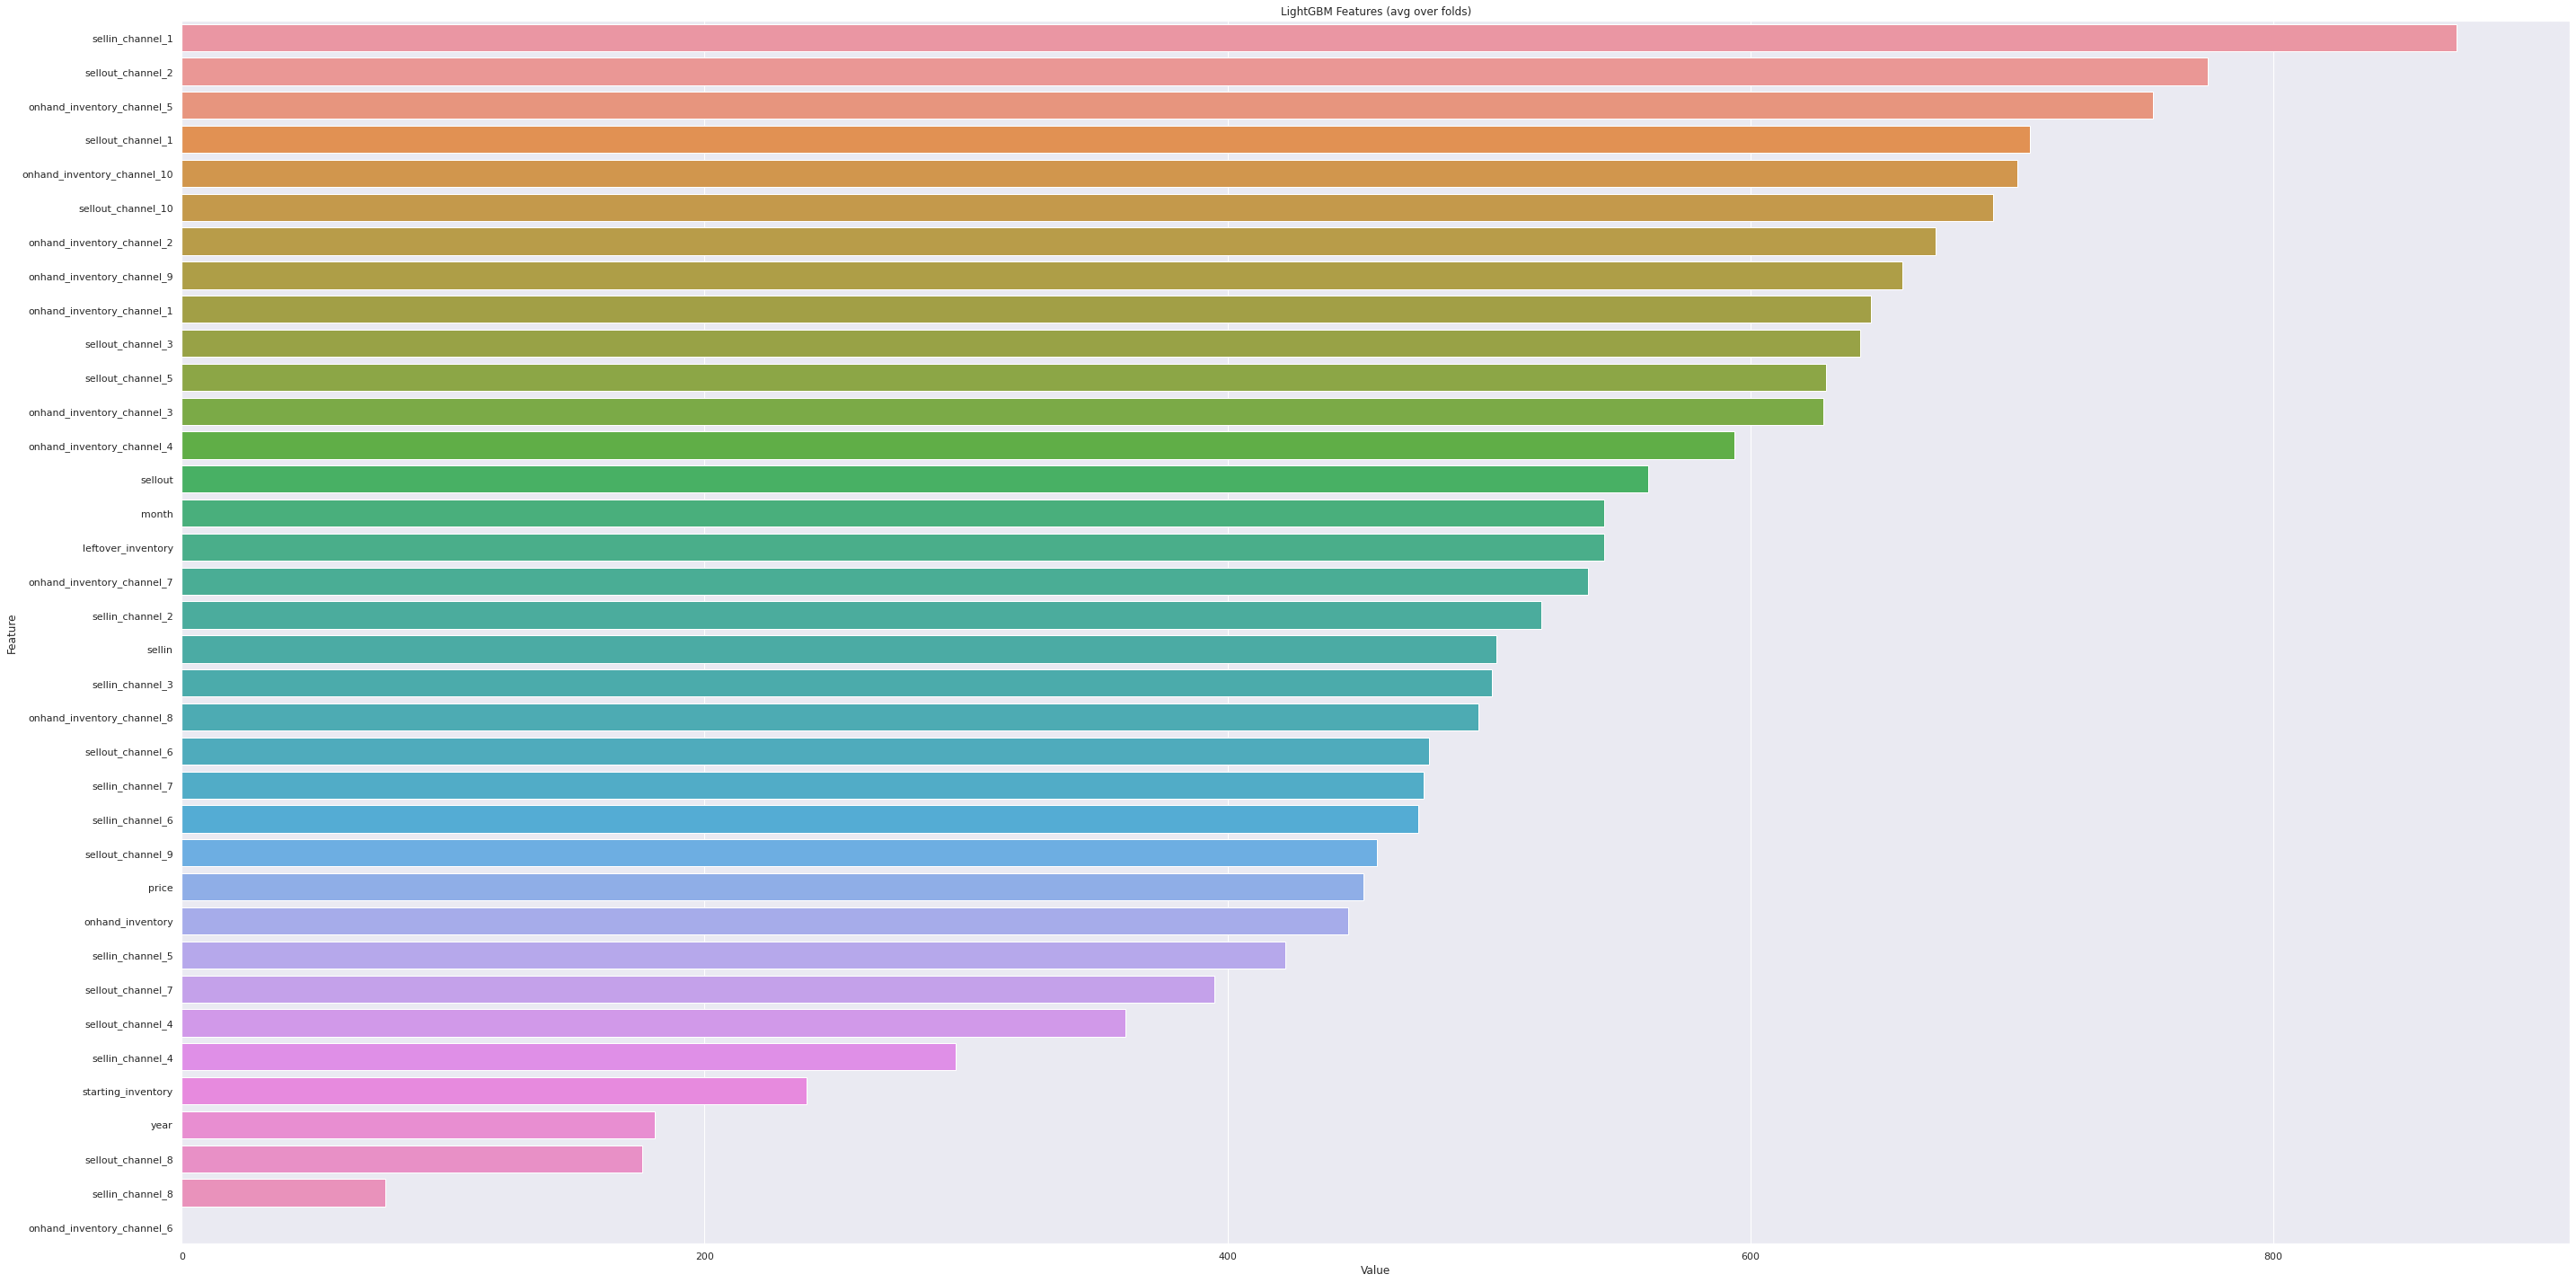

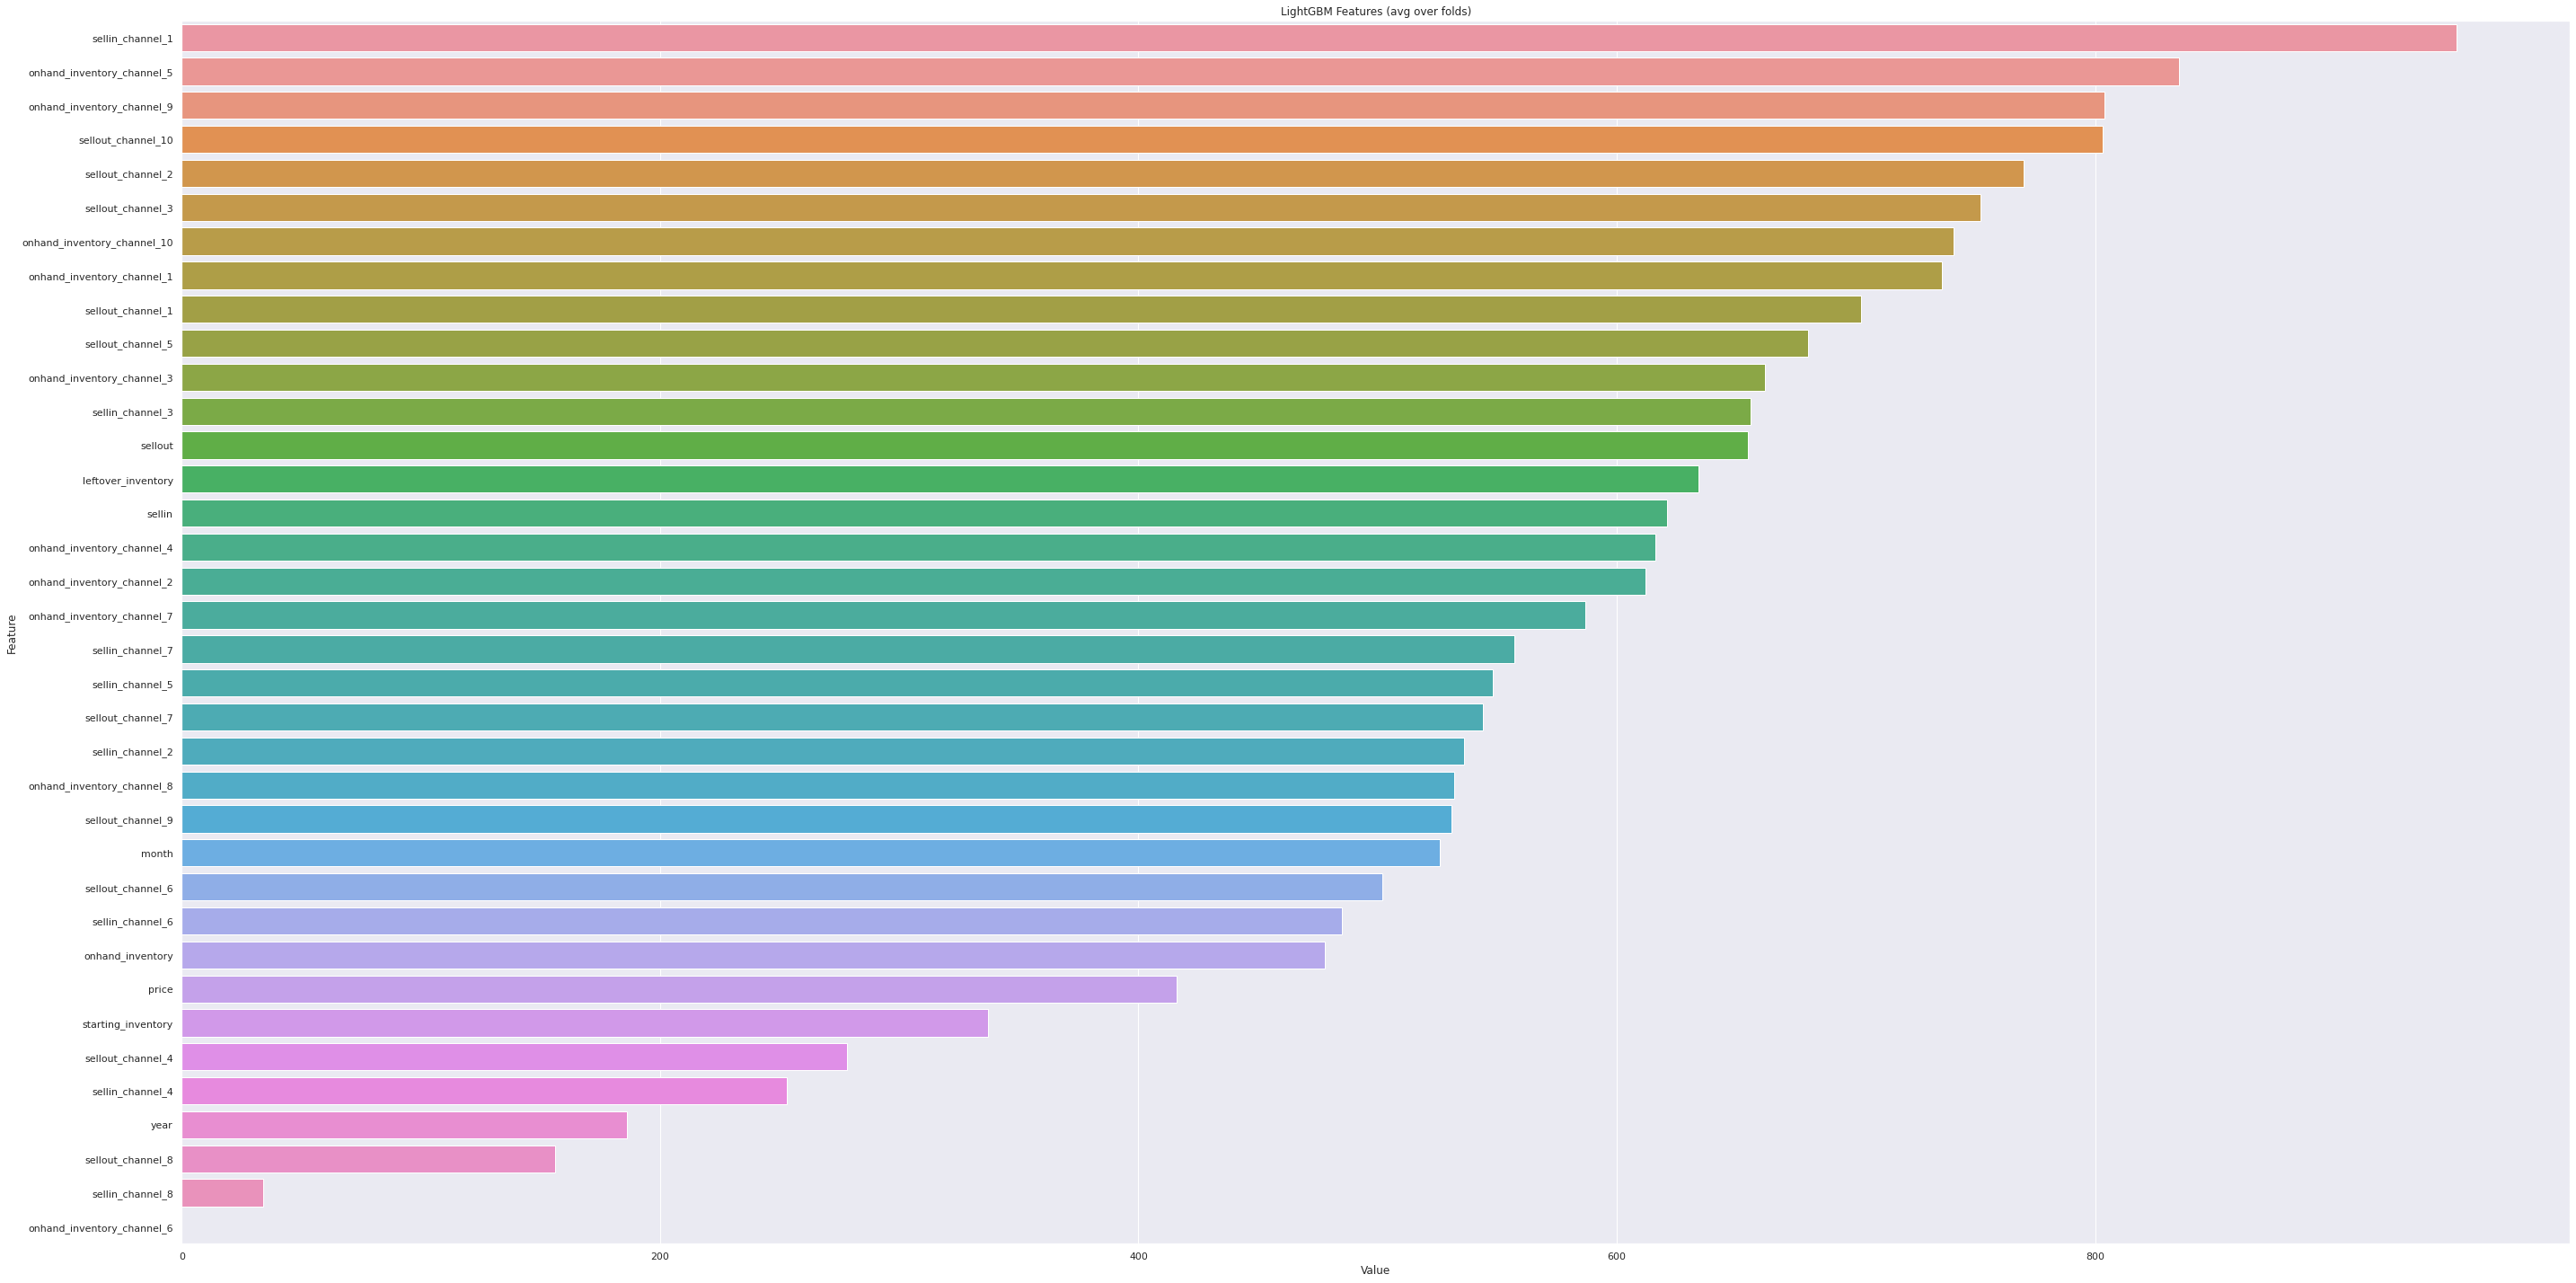

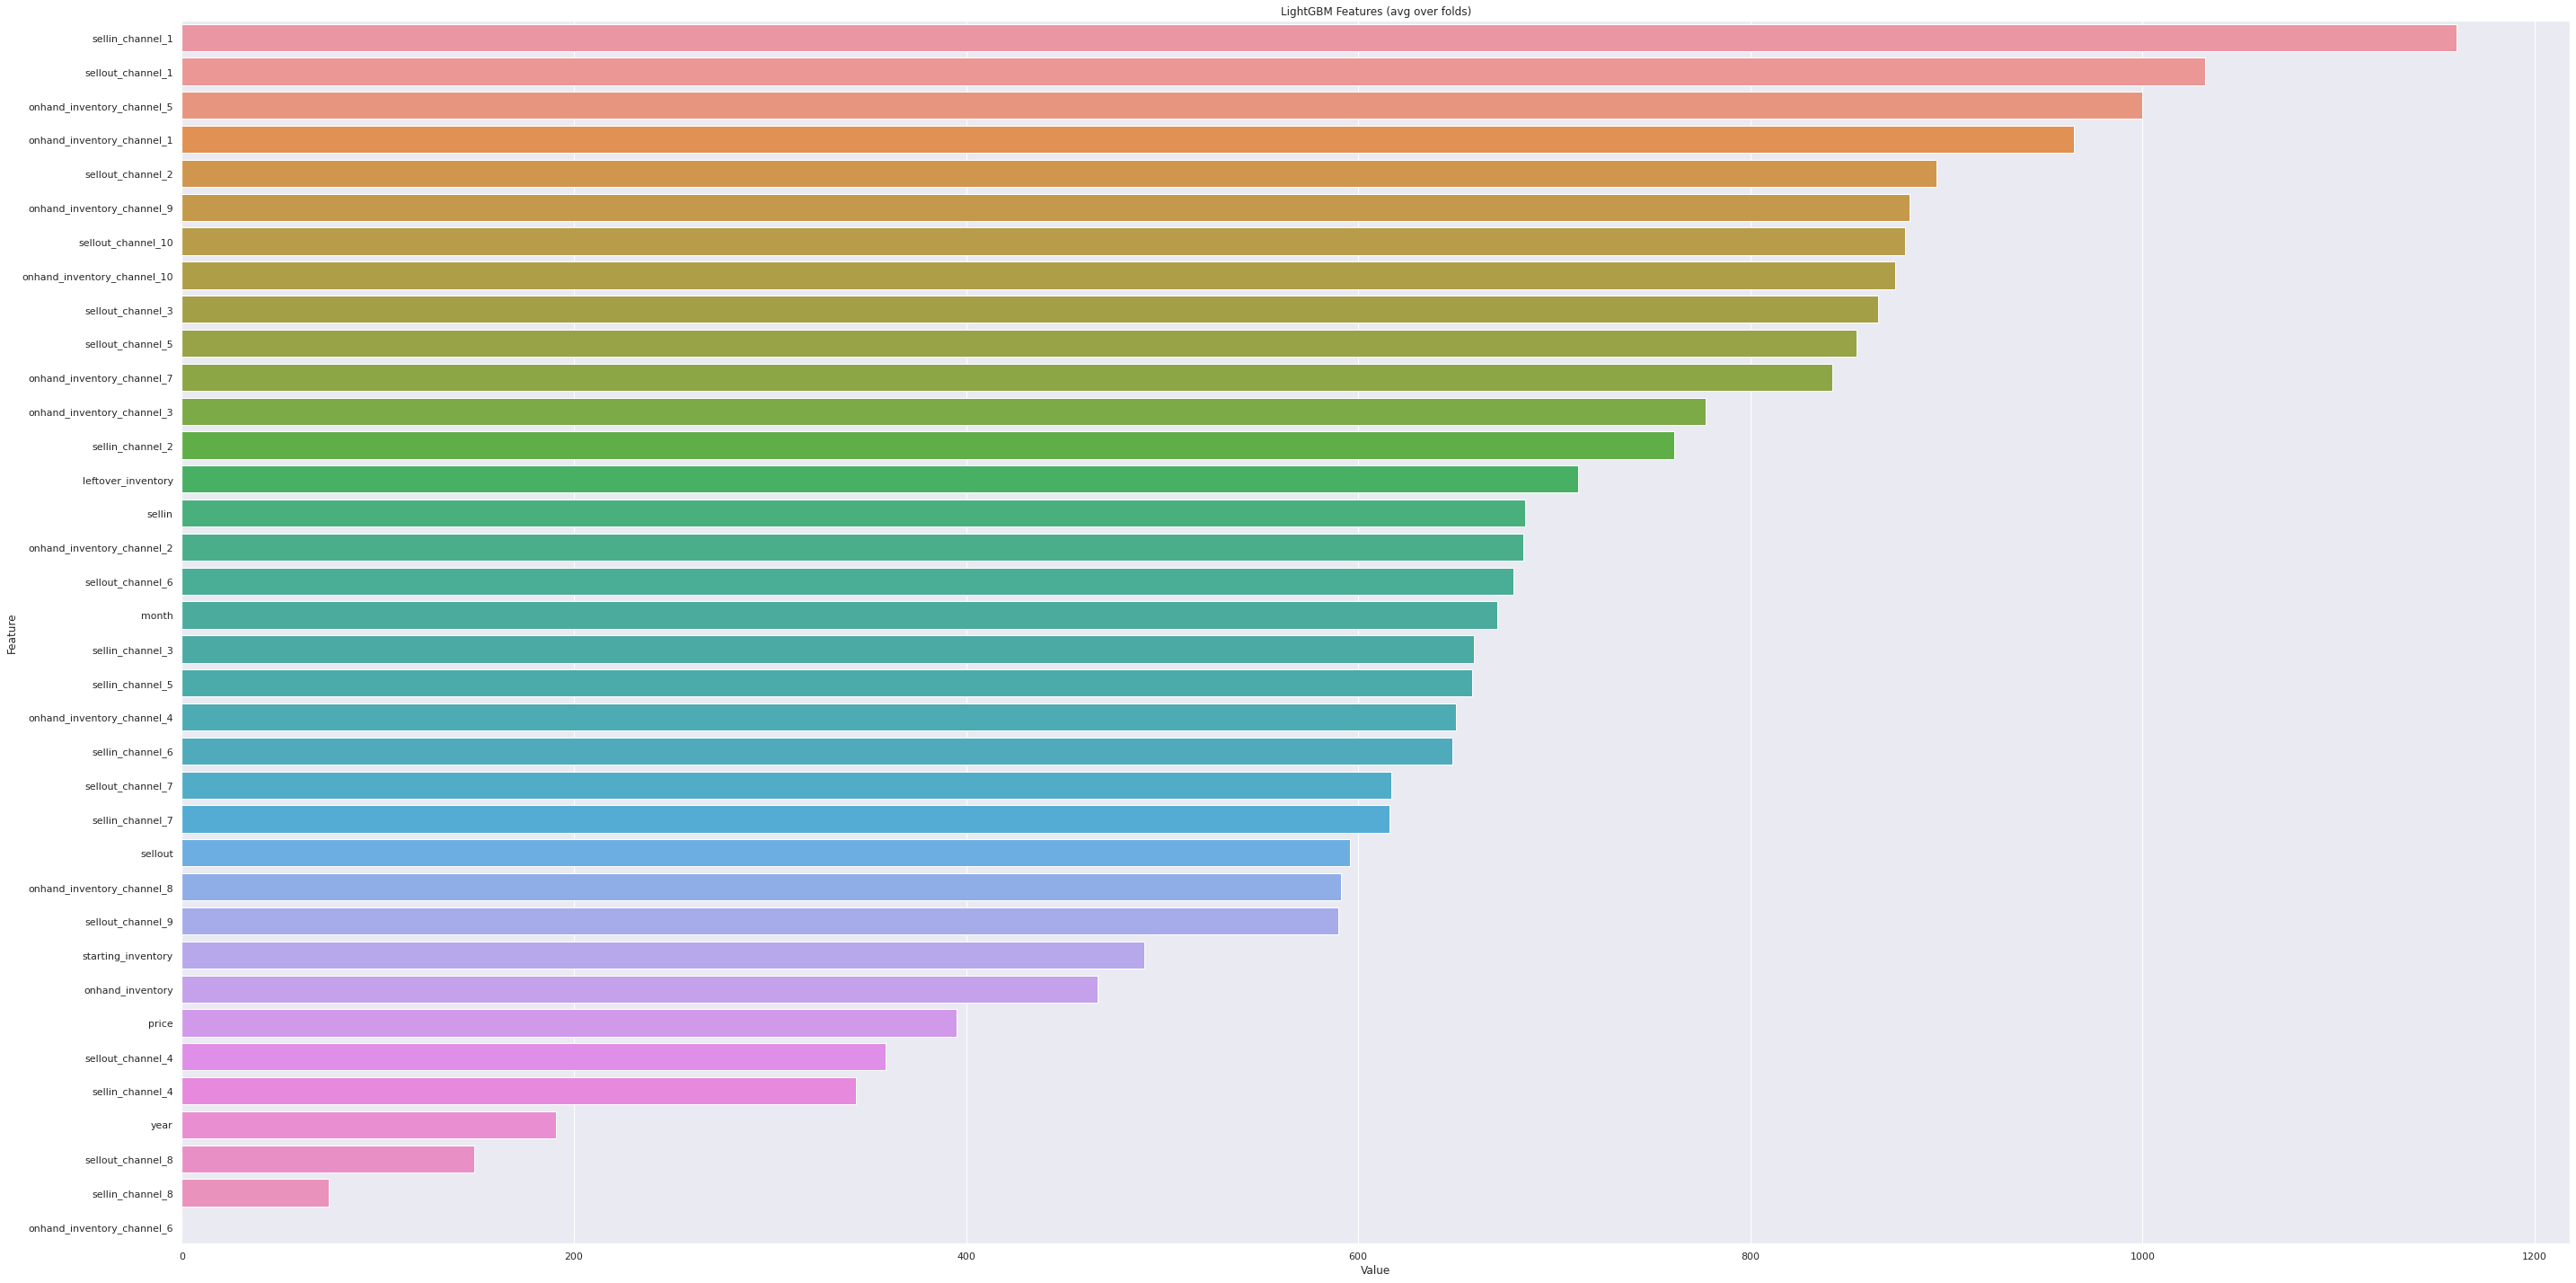

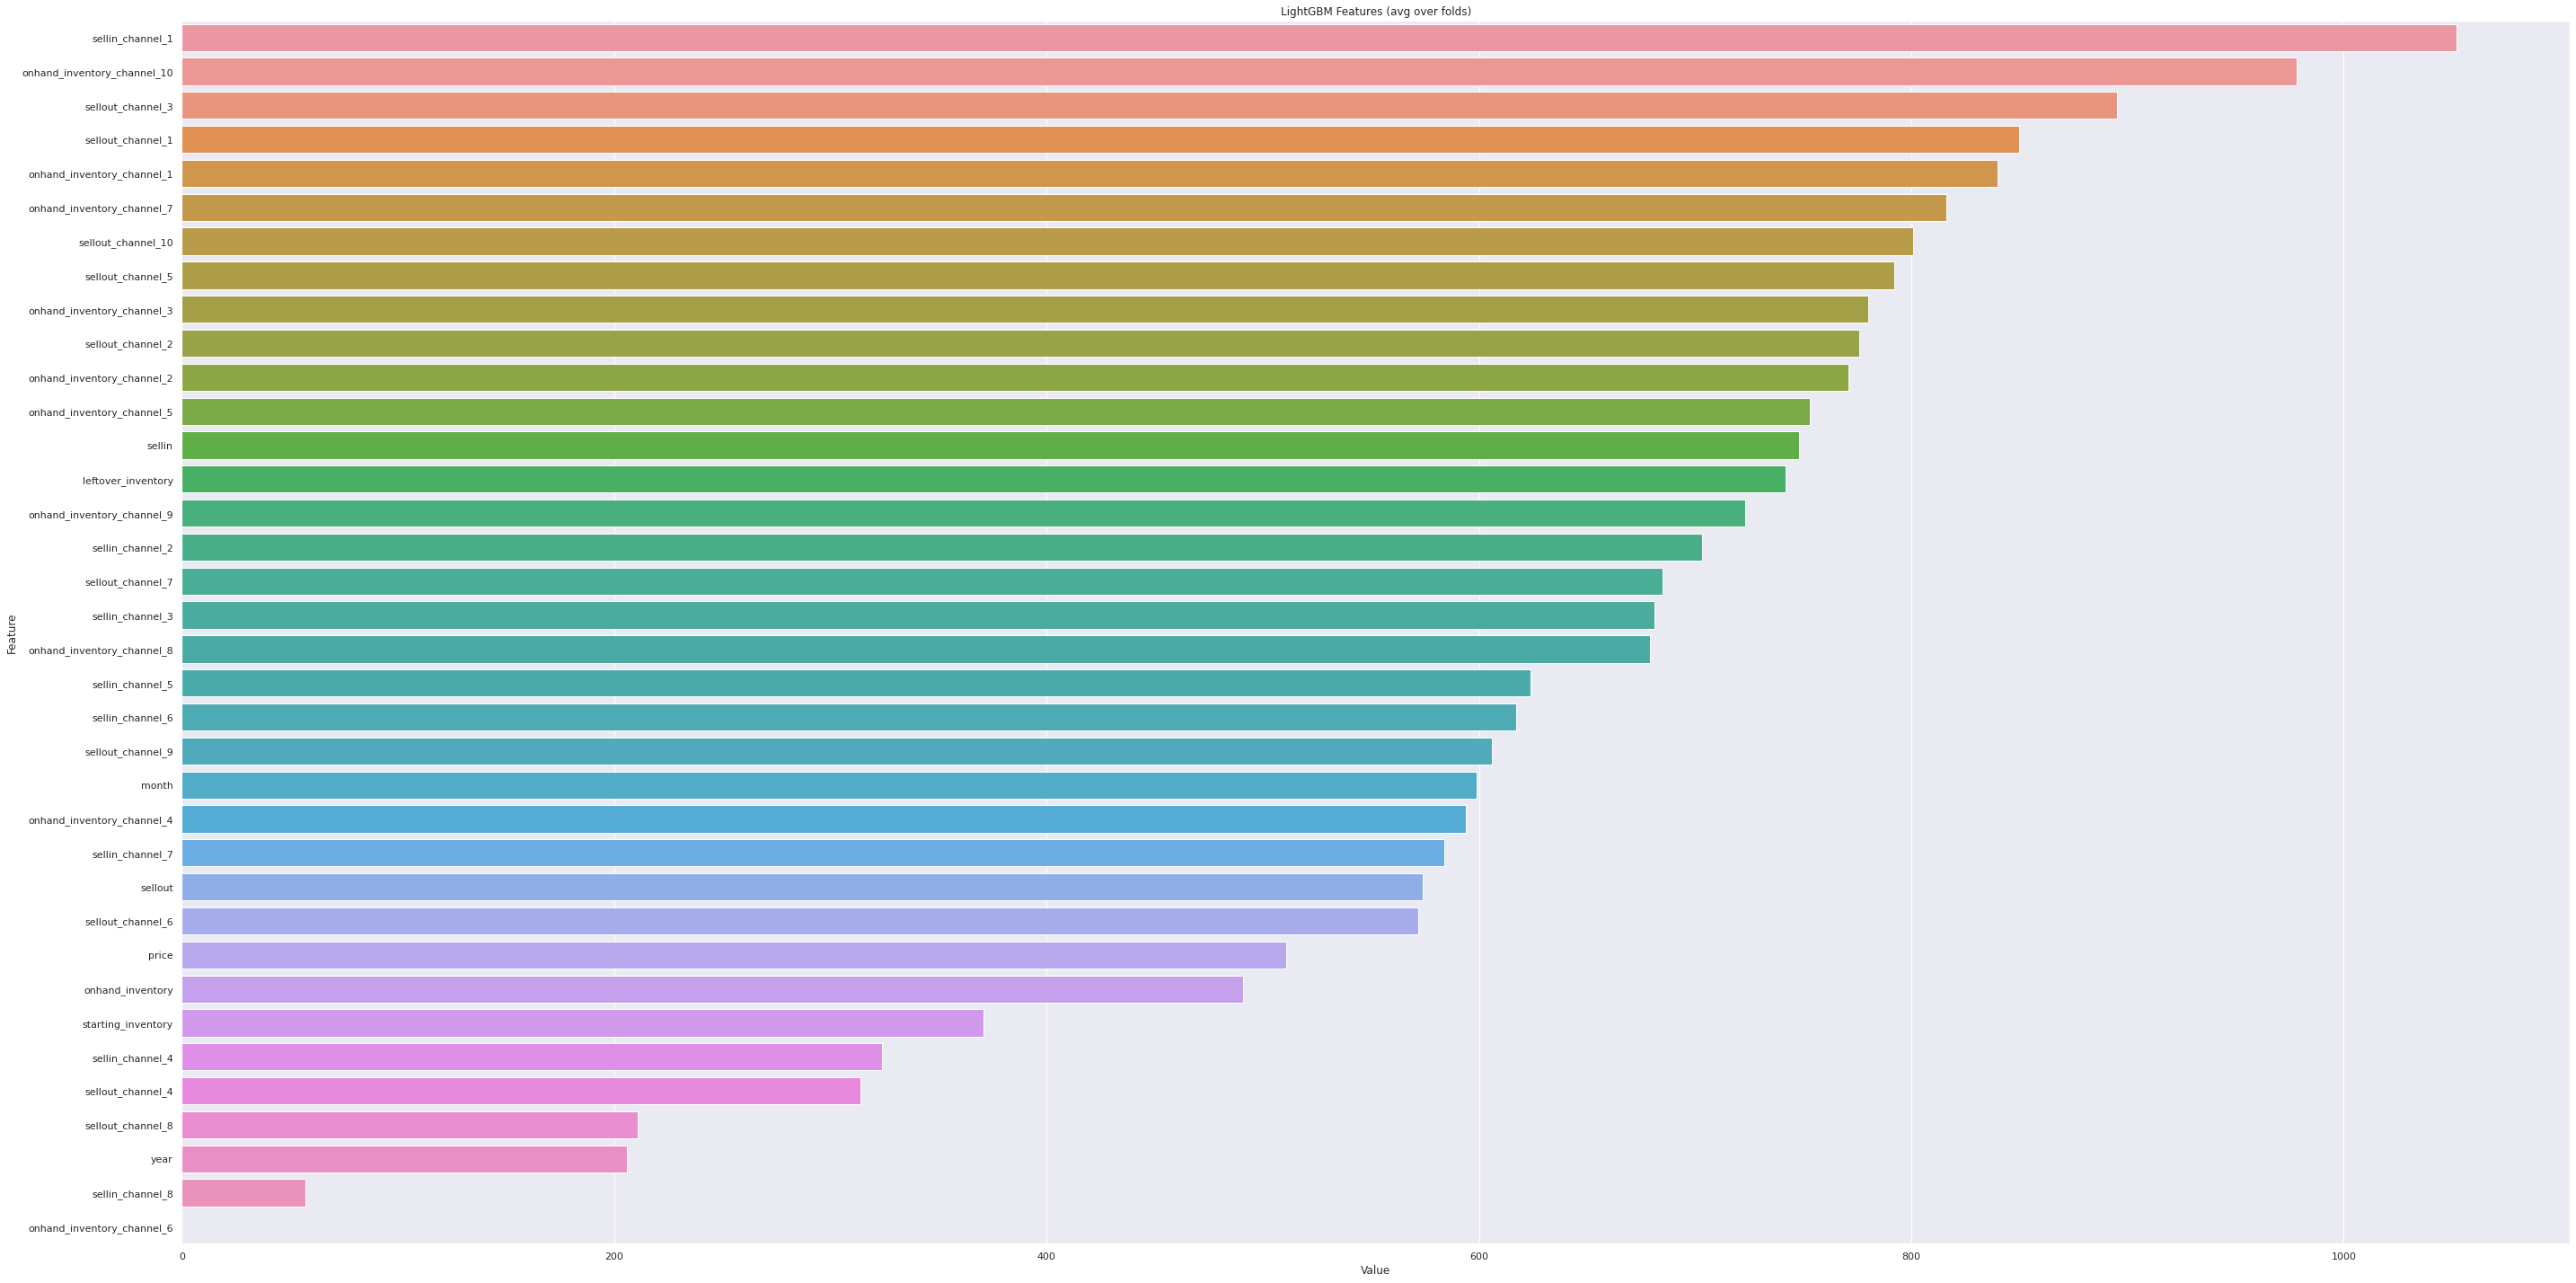

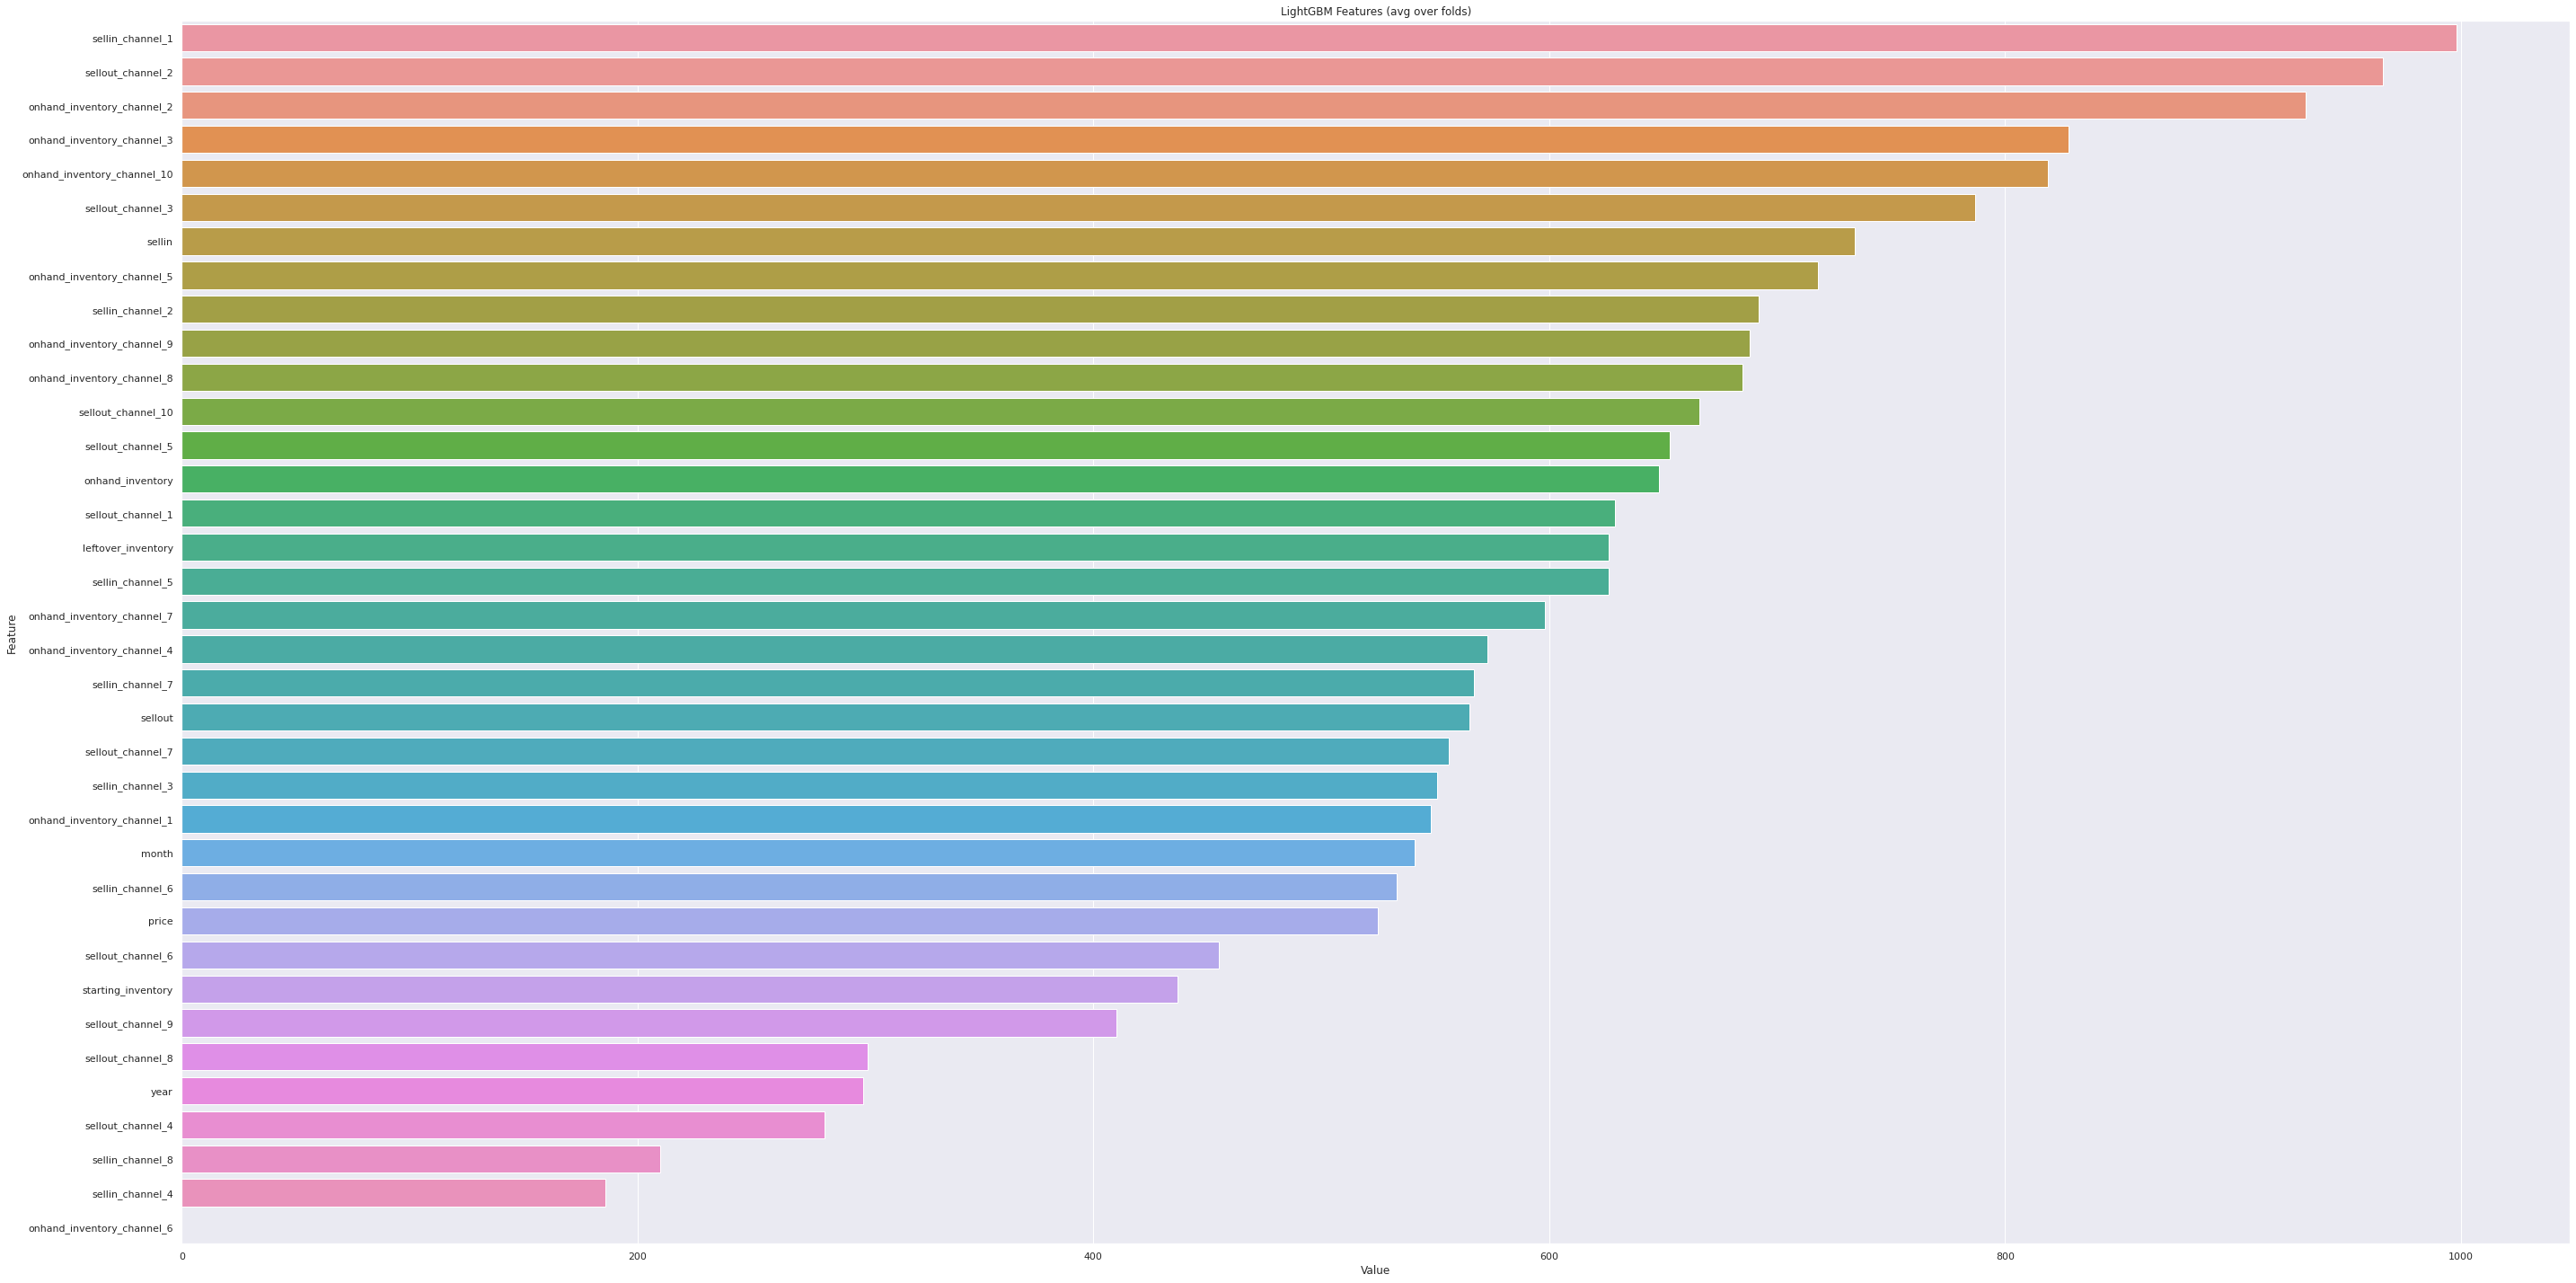

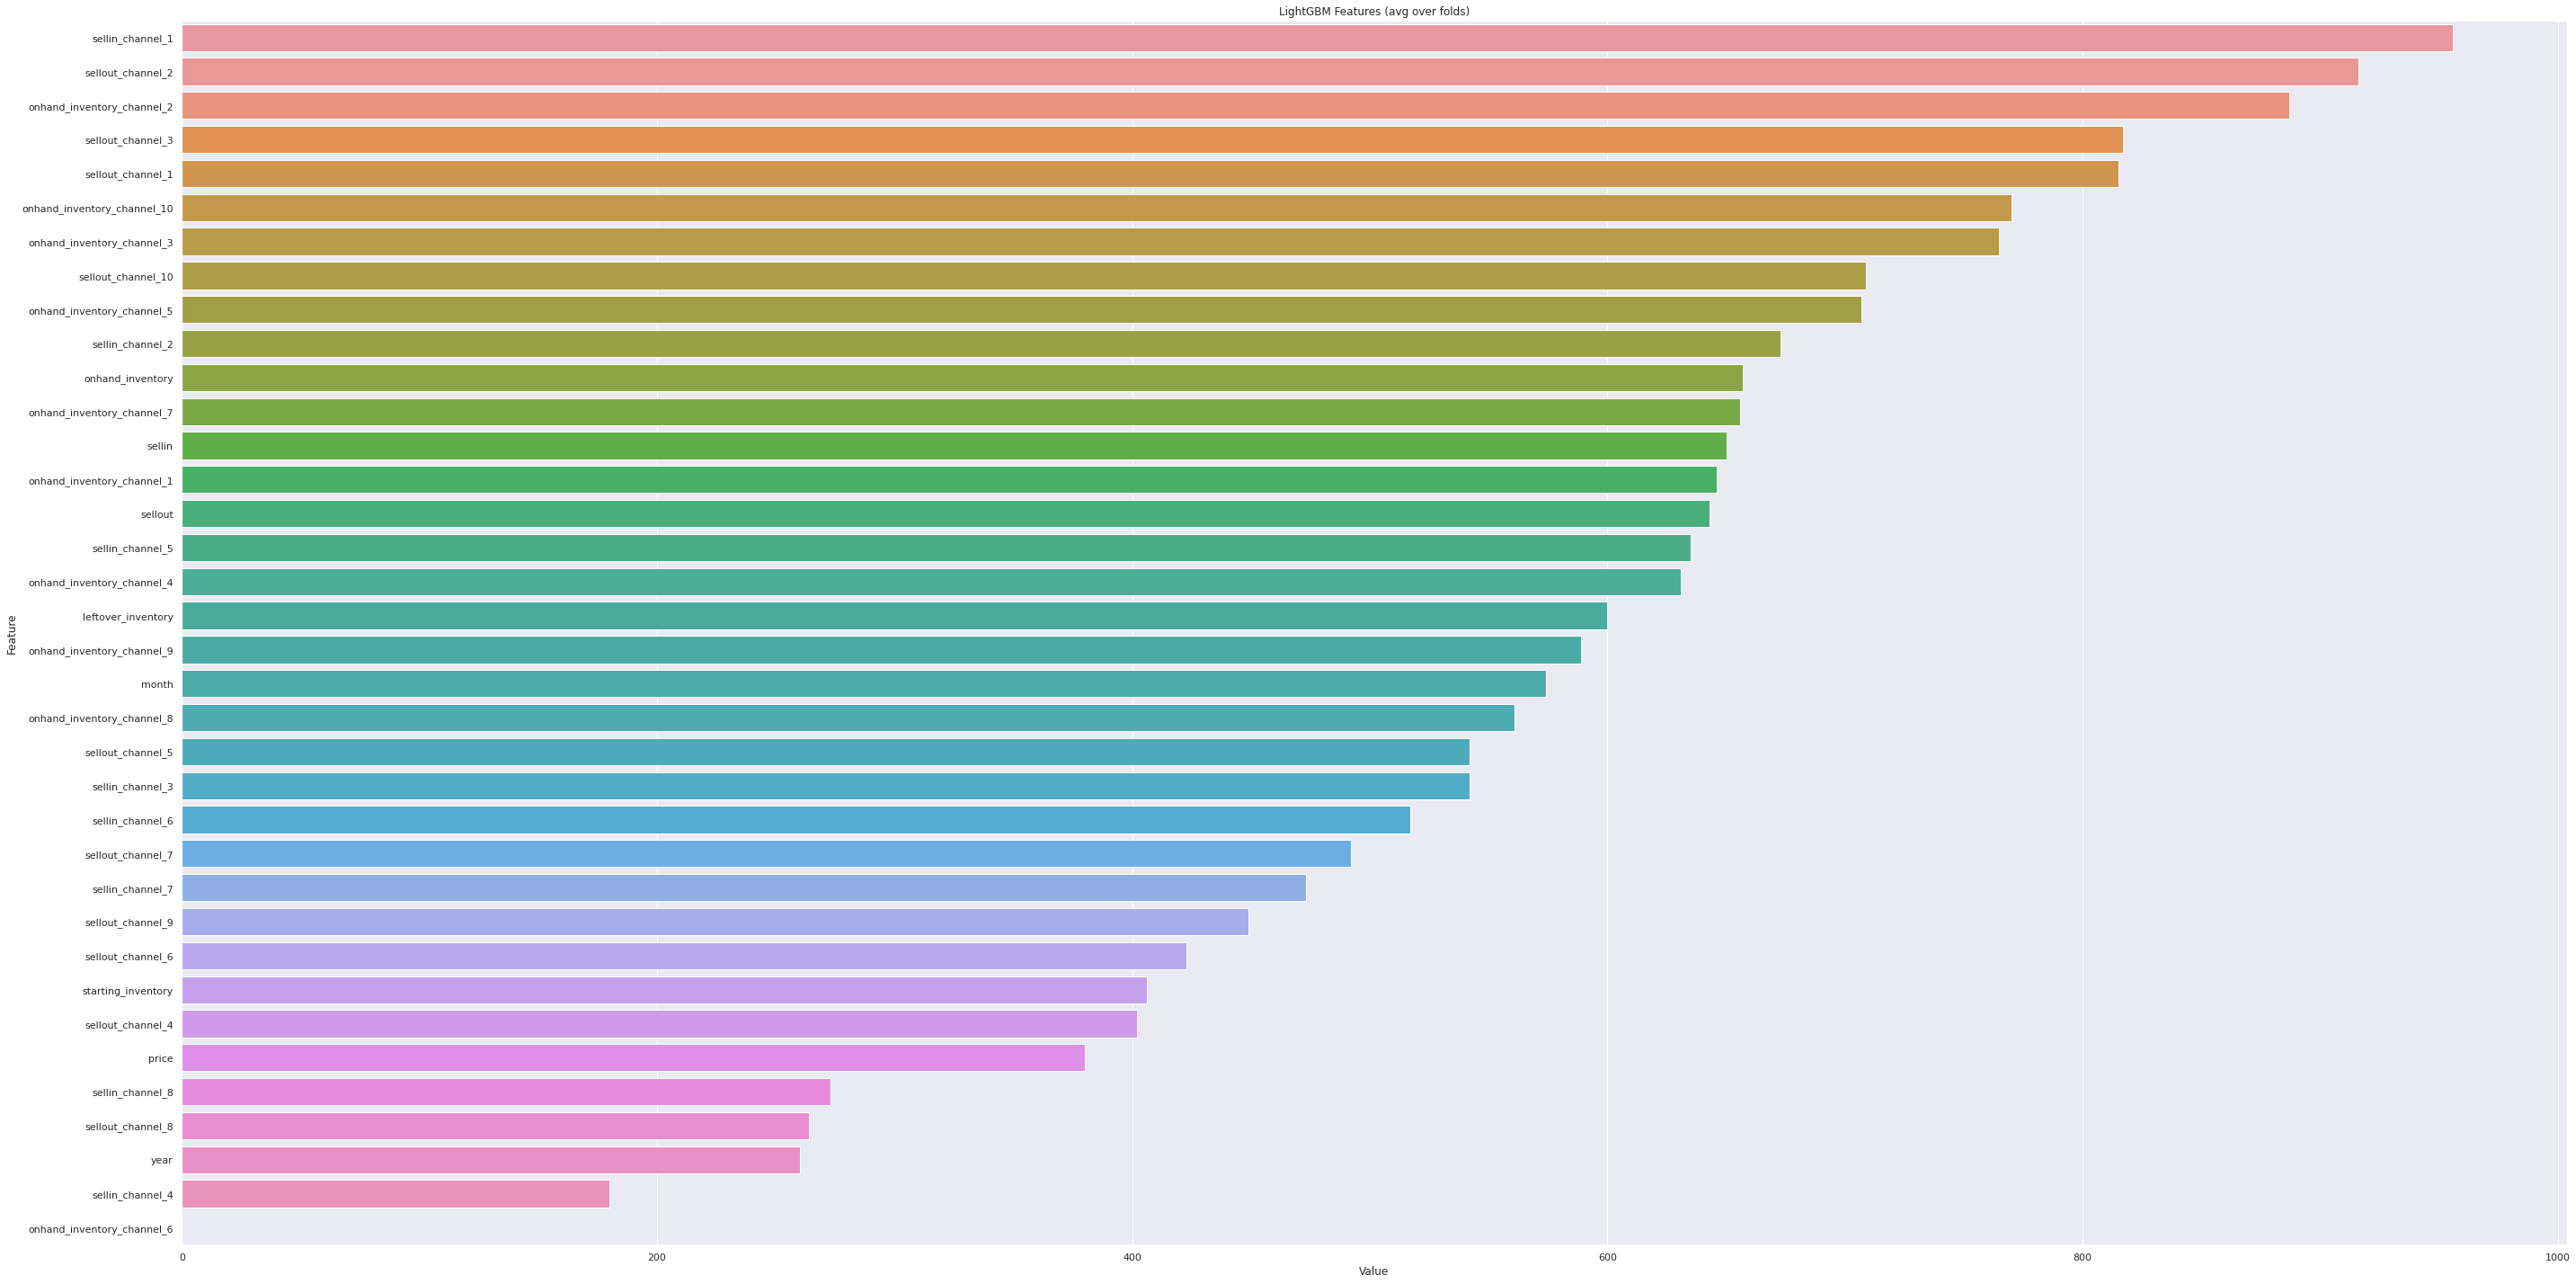

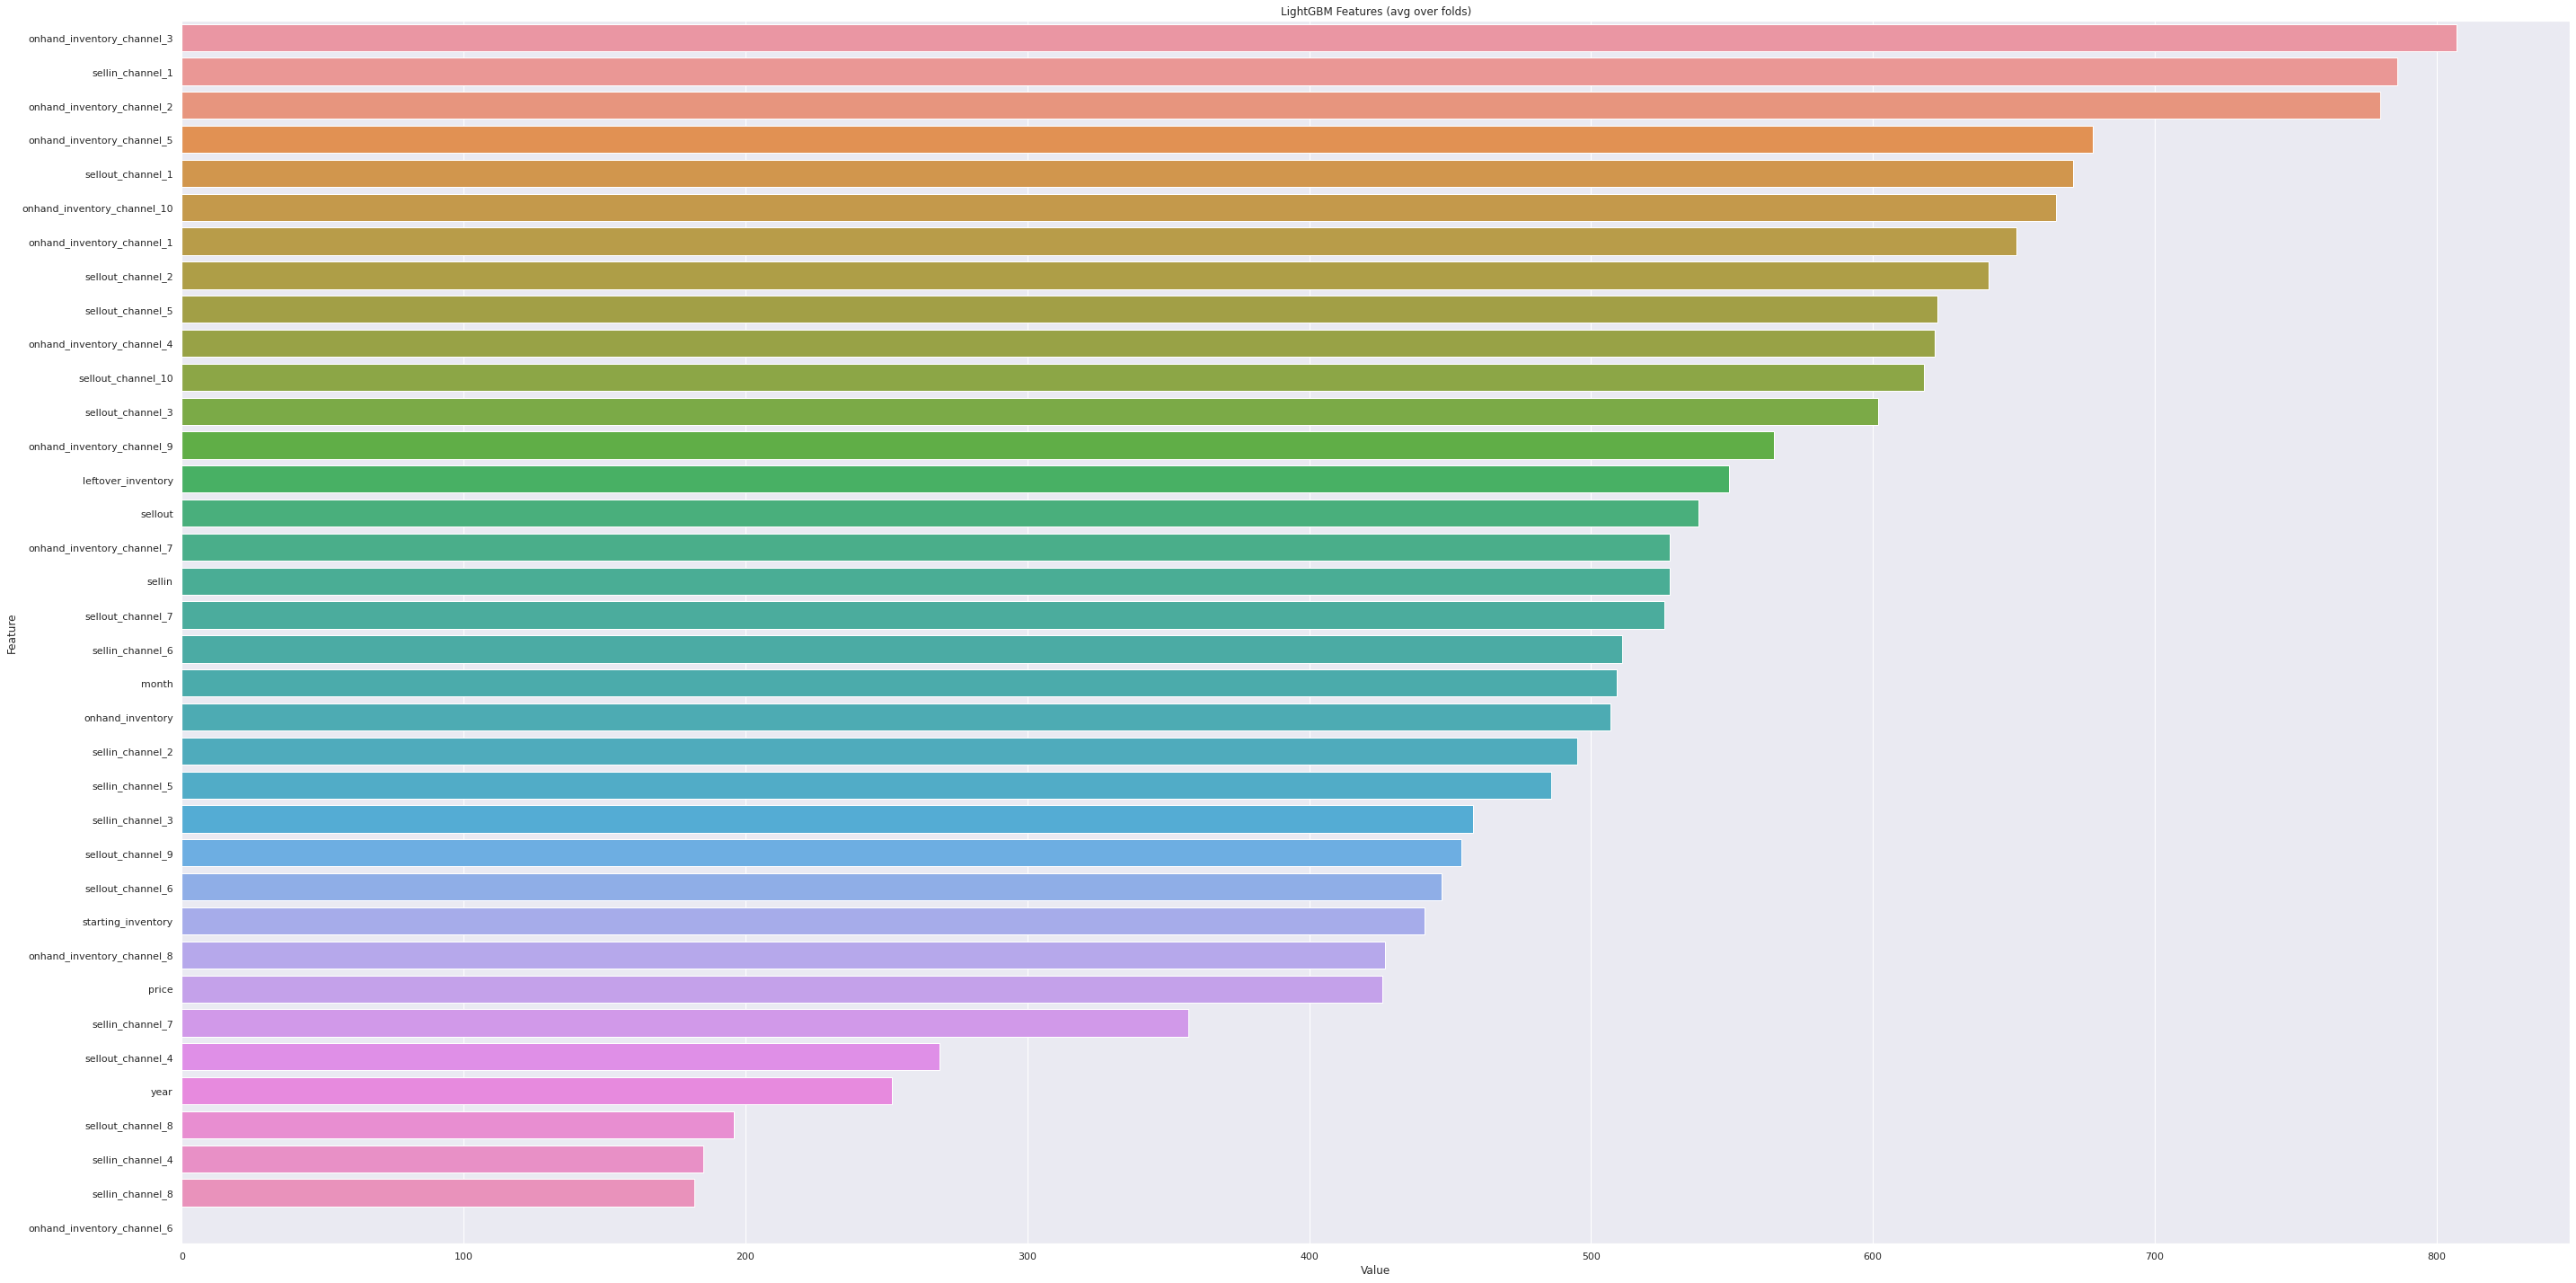

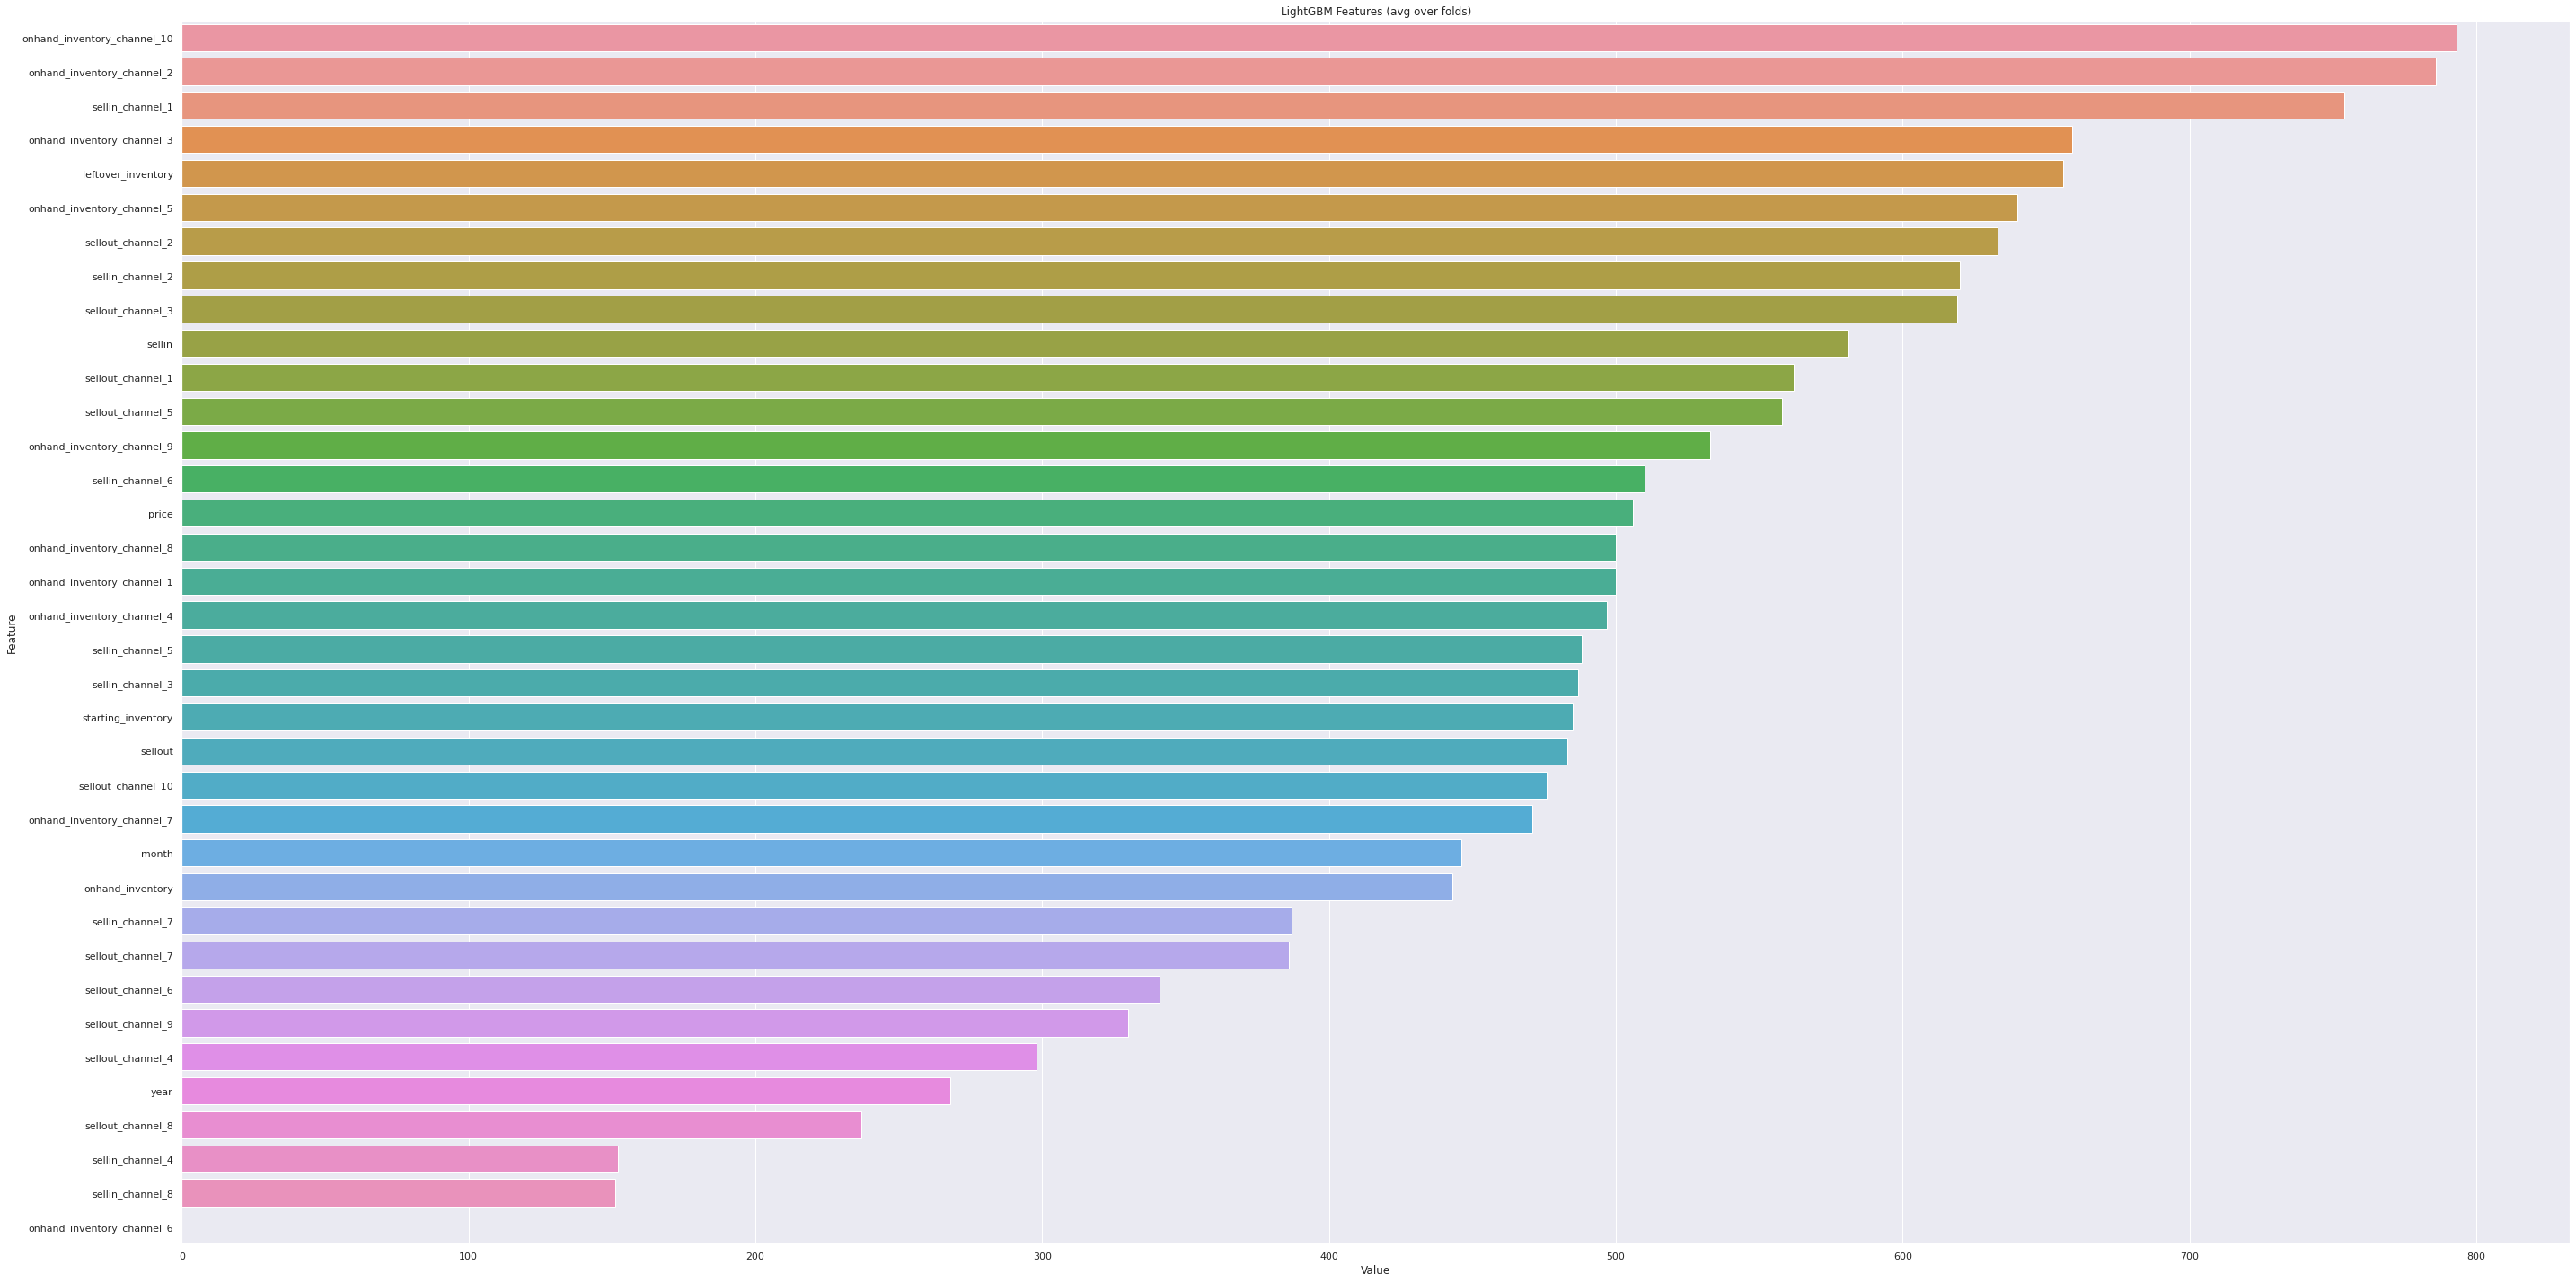

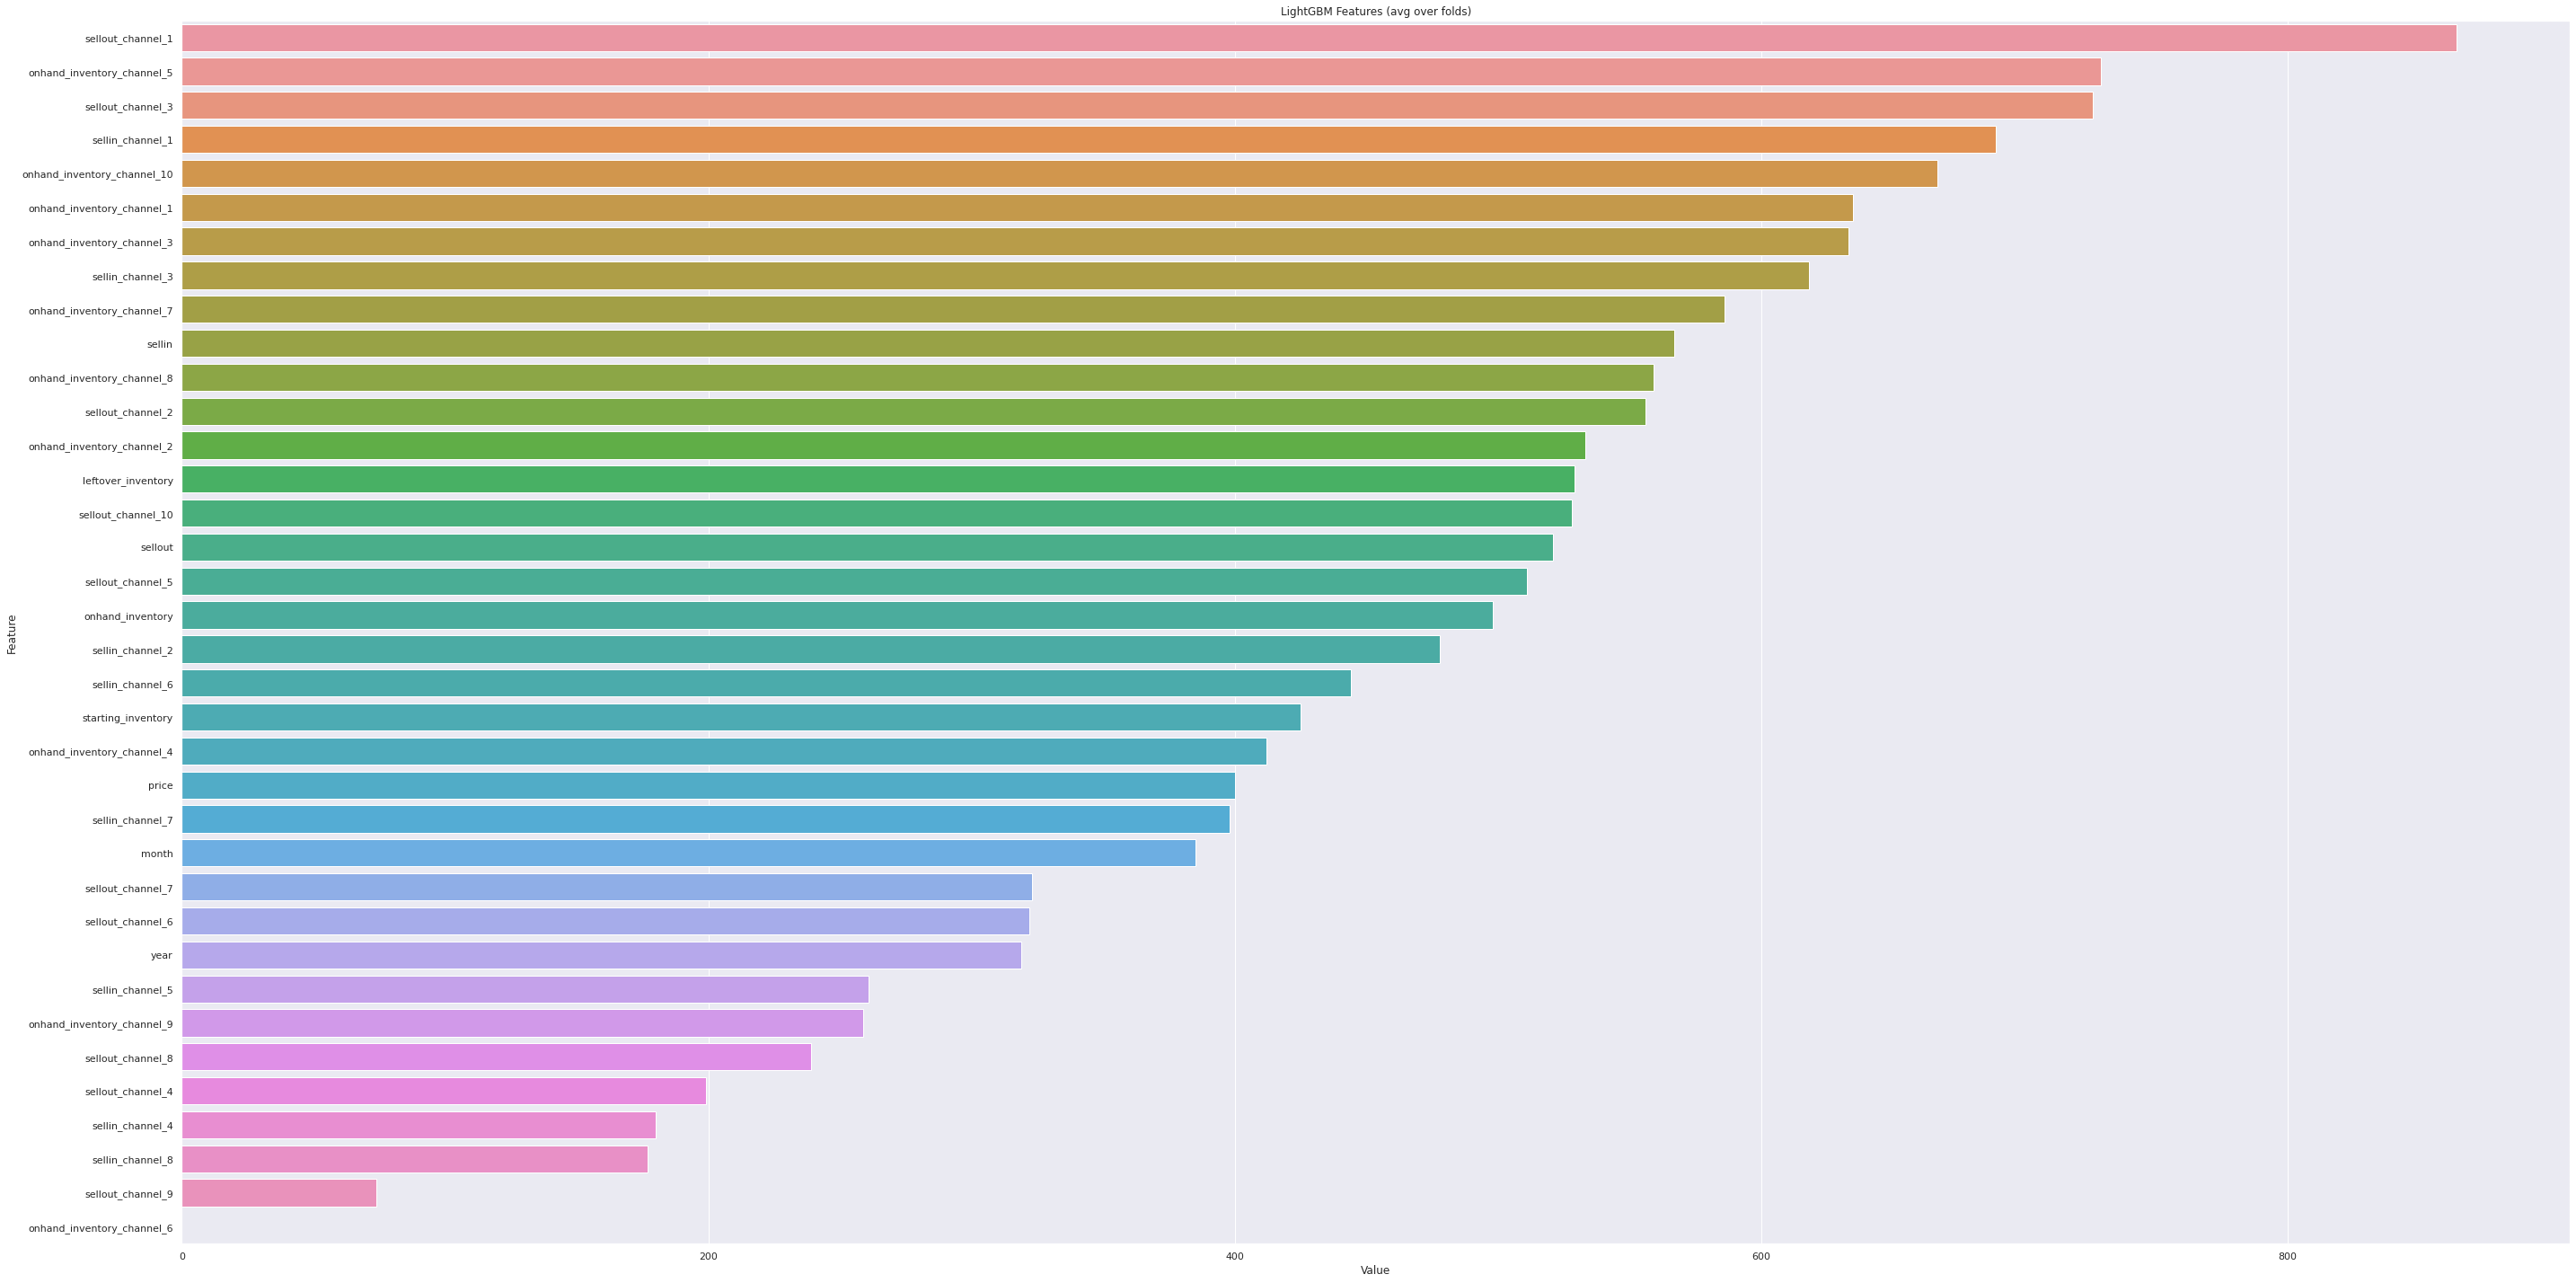

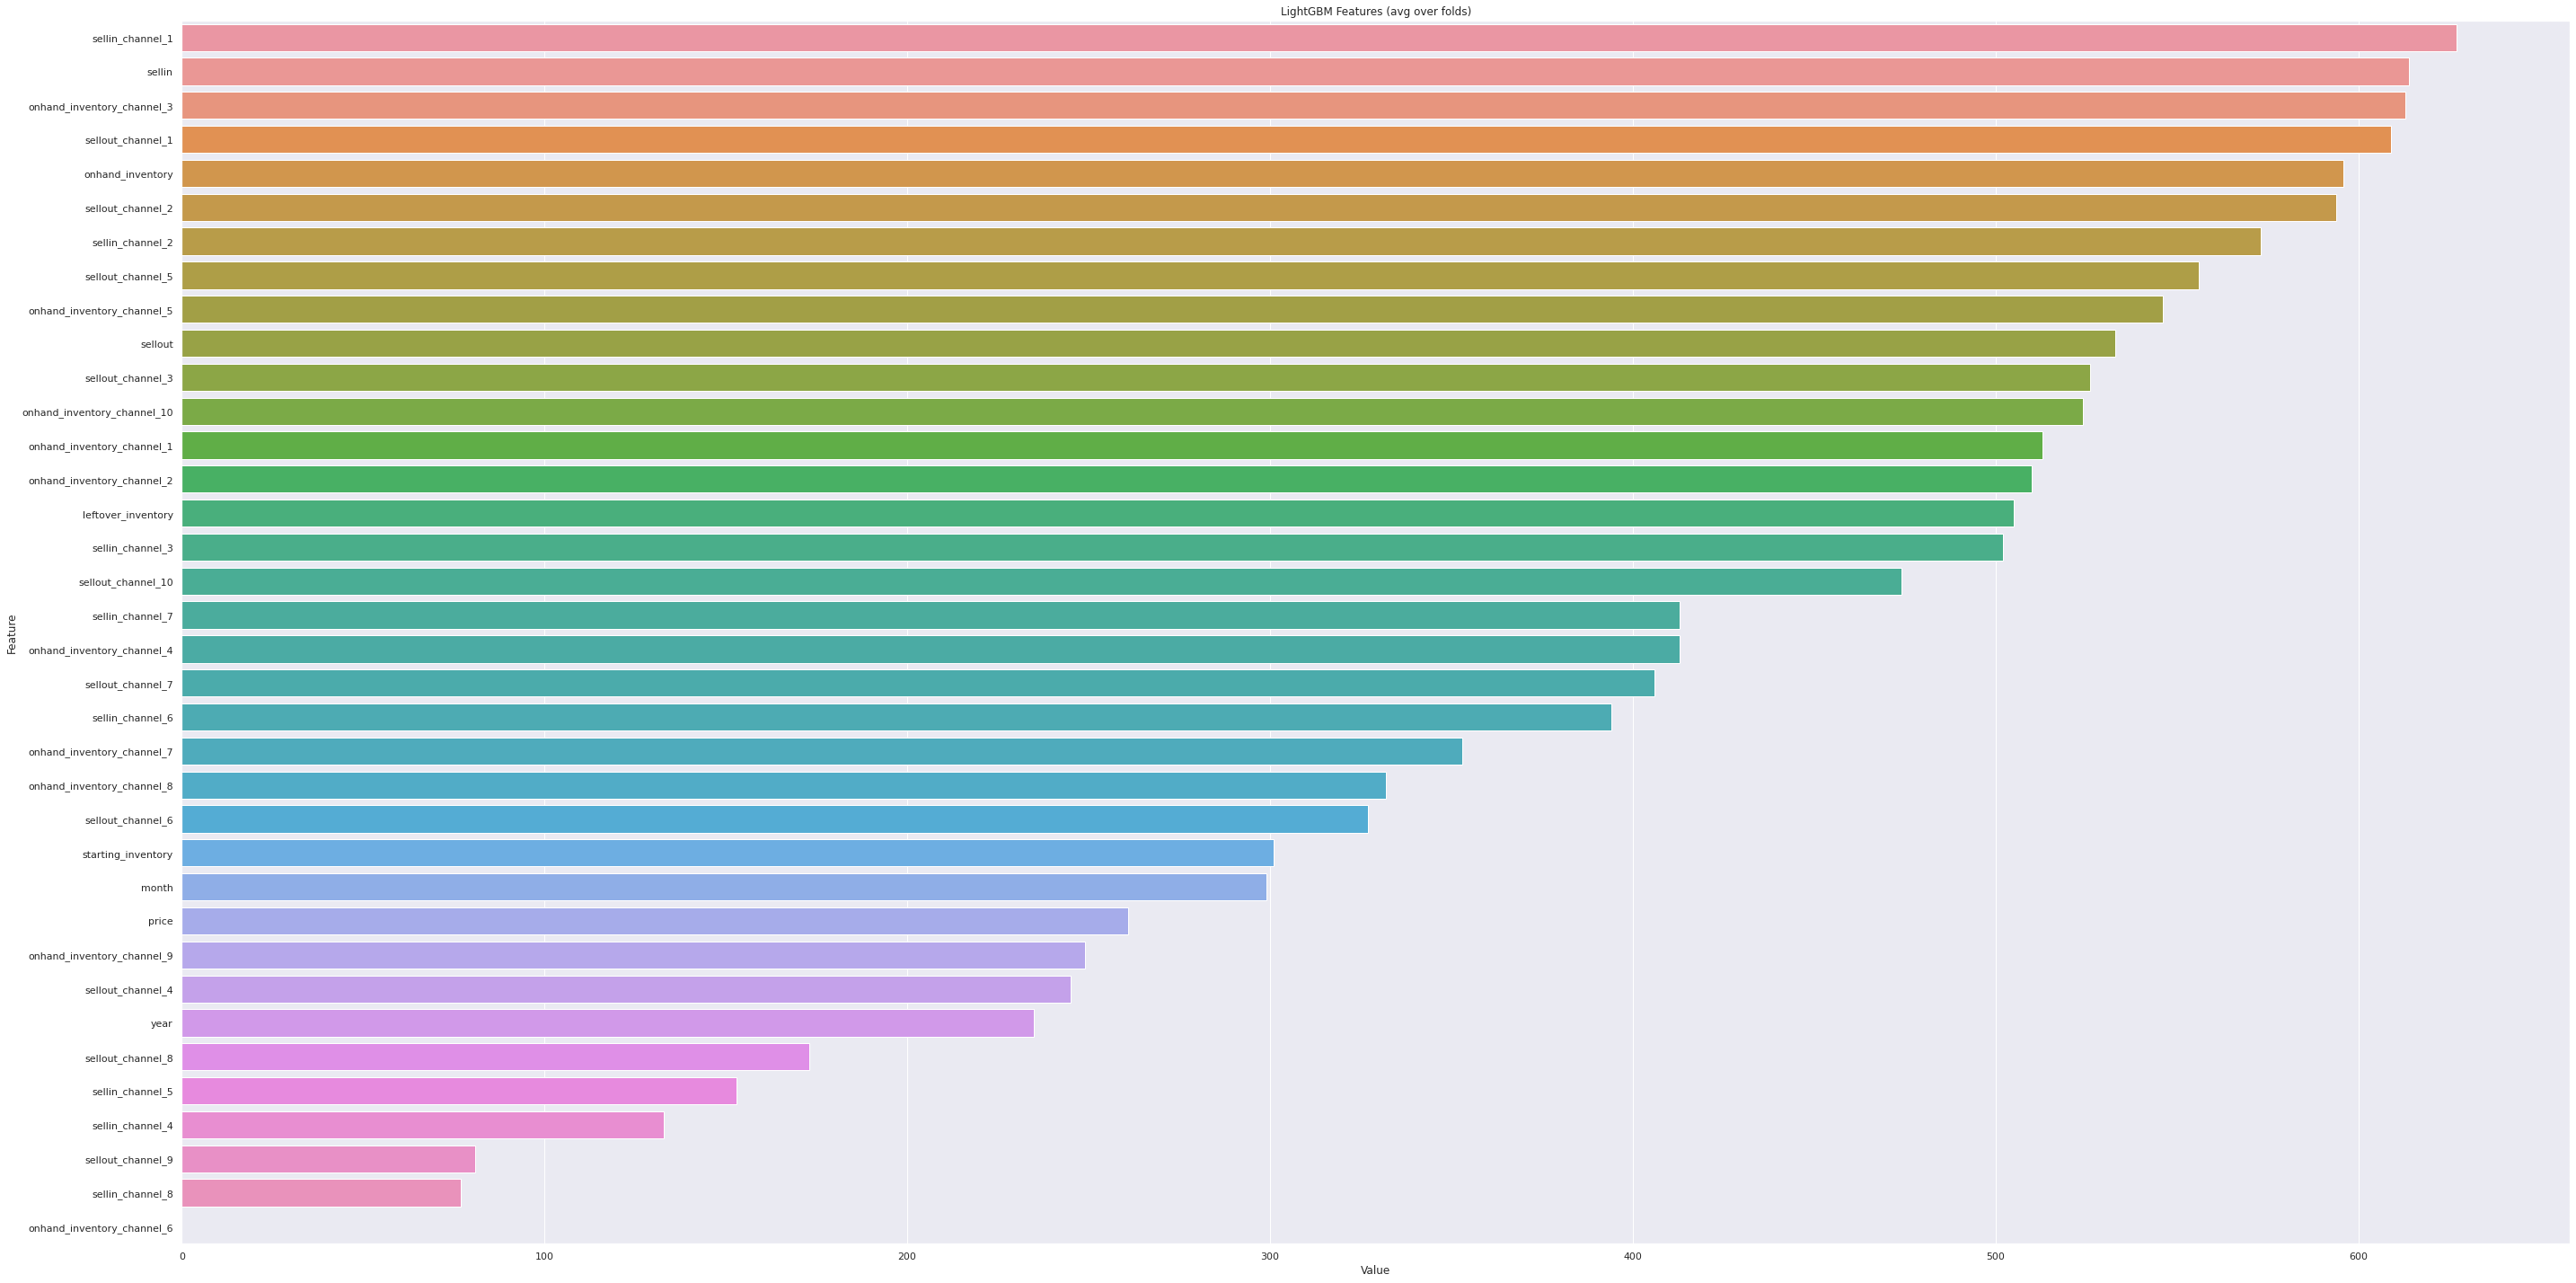

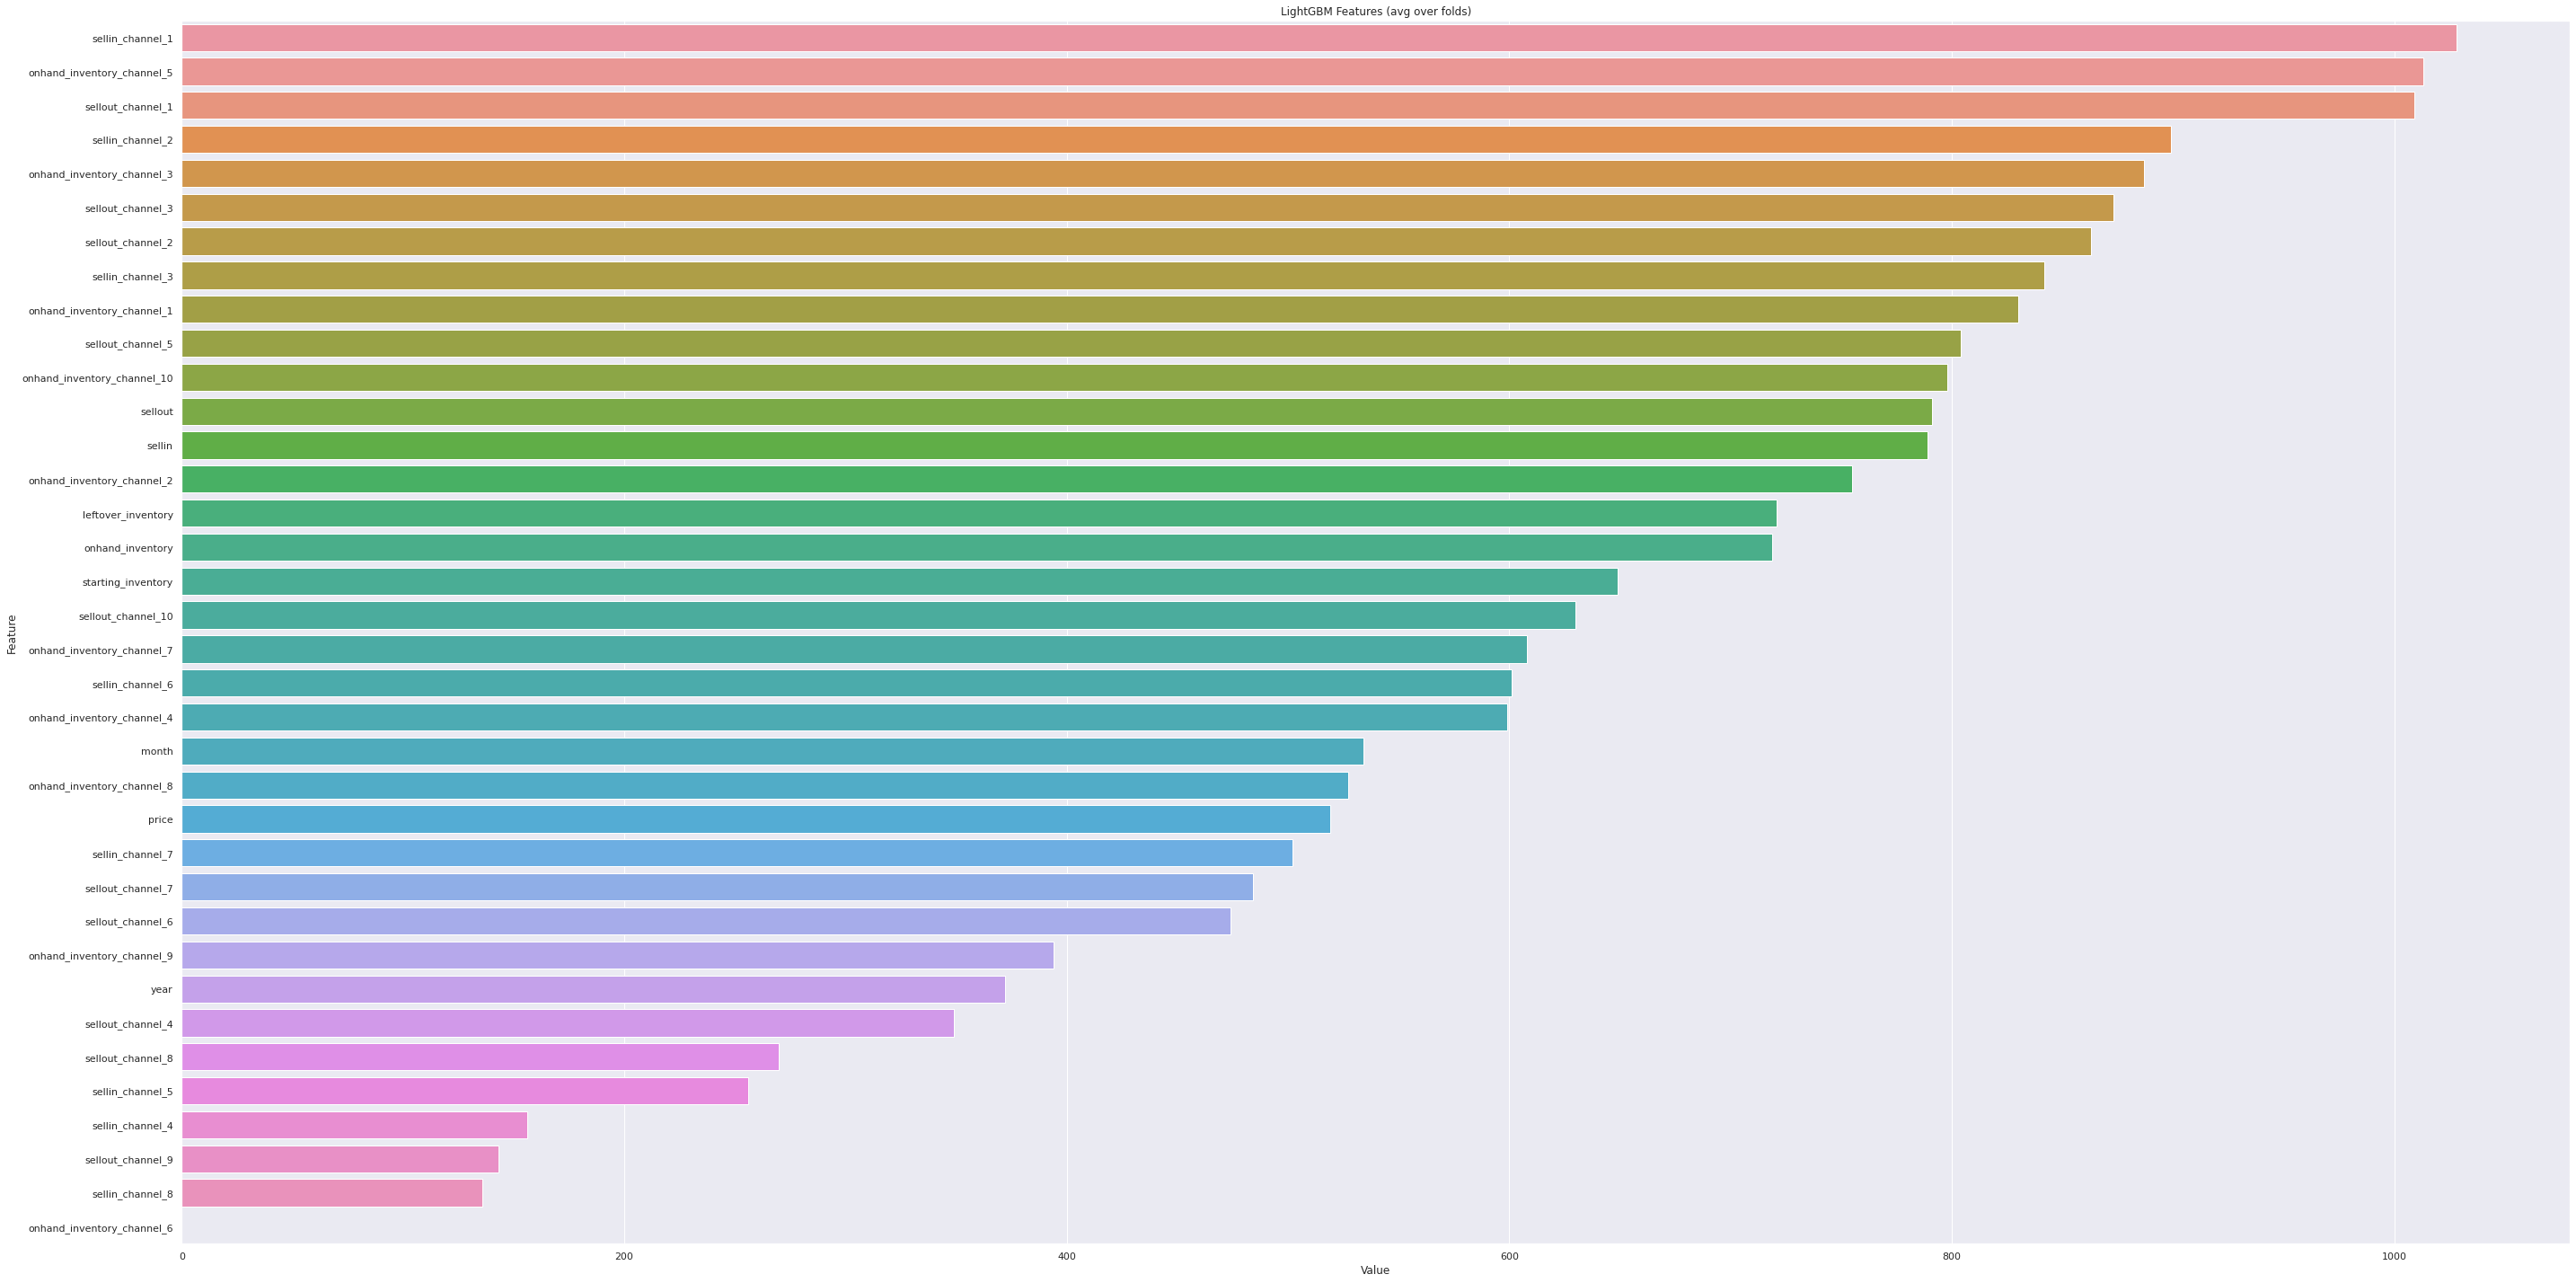

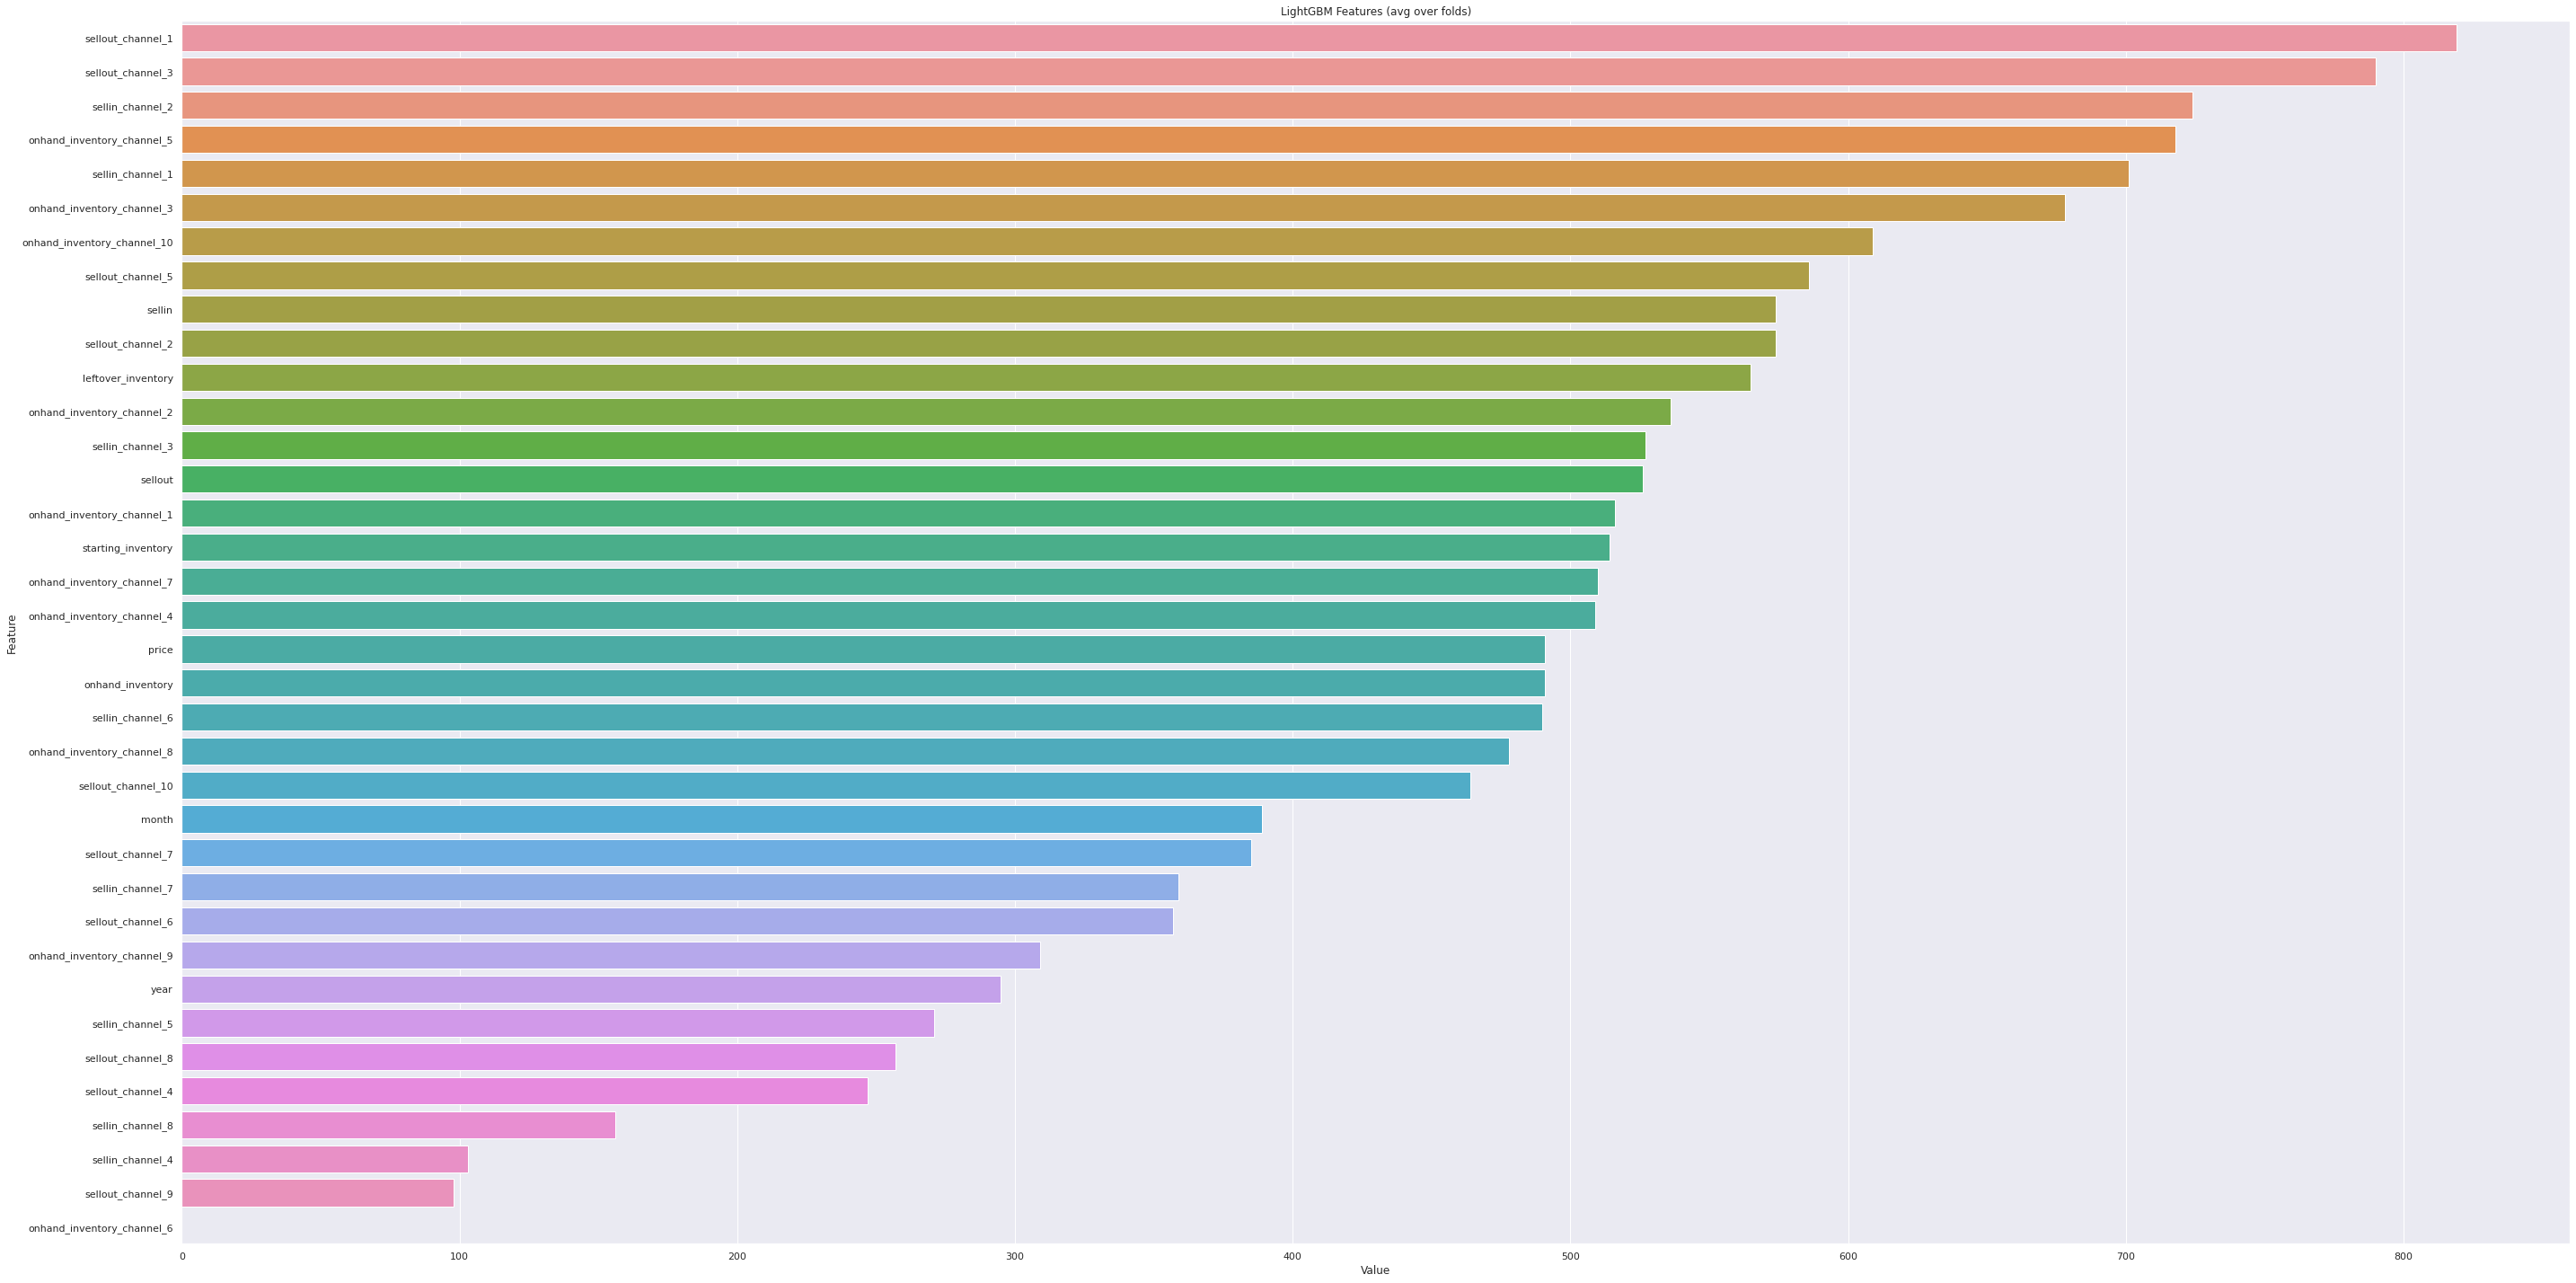

In [ ]:
feature_importance = cv_feature_importance_plot(train_data, val_data, folds, cv_models)

## Walk Forward Training and Validation

In [ ]:
expanding = True
metrics_list, loss_list, train_set, val_set = [], [], [], []

for ix in range(len(train_norm)):
    print(f'Training step {ix+1}:')
    print('\n')
    if expanding:
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        train_set = [train_norm[ix]]
        val_set = [val_norm[ix]]

    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    
    model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]

    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1:


Epoch 5: Train Loss: 0.0422	Val Loss: 0.0400	Val MAE: 532968.06	elapsed: 0.00 mins
Epoch 10: Train Loss: 0.0260	Val Loss: 0.0278	Val MAE: 445063.88	elapsed: 0.00 mins
Epoch 15: Train Loss: 0.0169	Val Loss: 0.0204	Val MAE: 384467.06	elapsed: 0.01 mins
Epoch 20: Train Loss: 0.0114	Val Loss: 0.0162	Val MAE: 367649.14	elapsed: 0.01 mins
Epoch 25: Train Loss: 0.0084	Val Loss: 0.0137	Val MAE: 341098.76	elapsed: 0.01 mins
Epoch 30: Train Loss: 0.0063	Val Loss: 0.0119	Val MAE: 329797.00	elapsed: 0.01 mins
Epoch 35: Train Loss: 0.0049	Val Loss: 0.0109	Val MAE: 322072.86	elapsed: 0.02 mins
Epoch 40: Train Loss: 0.0041	Val Loss: 0.0102	Val MAE: 316245.61	elapsed: 0.02 mins
Epoch 45: Train Loss: 0.0035	Val Loss: 0.0098	Val MAE: 314431.57	elapsed: 0.02 mins
Epoch 50: Train Loss: 0.0031	Val Loss: 0.0095	Val MAE: 311560.85	elapsed: 0.02 mins
Epoch 55: Train Loss: 0.0029	Val Loss: 0.0093	Val MAE: 309572.64	elapsed: 0.02 mins
Epoch 60: Train Loss: 0.0027	Val Loss: 0.0092	Val MAE: 308

## Training on Final Step

In [ ]:
def train_step(inputs, labels, model, optimizer, criterion, total_epochs, verbose):
    for epoch in range(total_epochs):
        optimizer.zero_grad()
        preds = model(inputs)

        loss = criterion(preds,labels)
        loss.backward()

        optimizer.step()
        if epoch % verbose==0 or epoch==(total_epochs-1):
            print('Epoch {}\tloss: {:.4f}'.format(epoch+1, loss.item()))

    return model.state_dict()


In [ ]:
def train_model(inputs, labels, num_features, num_products, epochs, verbose=5):
    weights = []

    for i,total_epochs in enumerate(epochs):
        model = FossilModel(num_features, 4, num_products, N_STEPS).double().to(ModelsConfig.device)
        optimizer = optim.AdamW(model.parameters(), lr=ModelsConfig.learning_rate)
        criterion = nn.L1Loss()
    
        print(f'Training model {i+1}:')
        weights.append(train_step(inputs, labels, model, optimizer, criterion, total_epochs, verbose))
        print('-'*50)
        print('\n')

    return weights

In [ ]:

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))
start_ix = len(dates)-2*LOOKBACK-N_STEPS
train_ix = len(dates)-LOOKBACK-N_STEPS
test_ix = len(dates)-LOOKBACK

x_train_date = dates[start_ix: train_ix]
y_train_date = dates[train_ix:test_ix]
test_date = dates[test_ix:]

In [ ]:
target_cols = ['sku_name', 'sellin', 'month', 'year']

x_train = train_df[train_df[['month', 'year']].apply(tuple, axis=1).isin(x_train_date)].reset_index(drop=True)
y_train = train_df[train_df[['month', 'year']].apply(tuple, axis=1).isin(y_train_date)].reset_index(drop=True)

x_train['sku_name'] = x_train['sku_name'].apply(sku_encoder).reset_index(drop=True)
y_train['sku_name'] = y_train['sku_name'].apply(sku_encoder).reset_index(drop=True)

y_train = _pad_target(x_train, y_train, sku_encoder)
x_train = x_train.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)

y_train['sellin'] = y_train.groupby(['sku_name'])['sellin'].transform(lambda x: x.fillna(x.mean()))
y_train['sellin'] = y_train.groupby(['year', 'month'])['sellin'].transform(lambda x: x.fillna(x.mean()))
y_train = y_train.groupby(['sku_name','year','month']).mean().reset_index()[target_cols]

In [ ]:

x_cols = [c for c in x_train.columns if 'sku_name' not in c]
y_cols = [c for c in y_train.columns if 'sku_name' not in c]

x_scaler.fit(x_train.drop(columns=['sku_name']))
y_scaler.fit(y_train.drop(columns=['sku_name']))
target_scaler.fit(x_train['sellin'].values.reshape(-1,1))

x_train[x_cols] = x_scaler.transform(x_train[x_cols])
y_train[y_cols] = y_scaler.transform(y_train[y_cols])


In [ ]:
features = [c for c in x_train.columns if c not in ['sku_name','year','month']]
feat_group = x_train.sort_values(['sku_name','year','month']).groupby(['month','year'])

seq = np.array([v.drop(columns=['sku_name','year','month']) for k,v in feat_group]) #(timesteps, products, features)
seq = torch.as_tensor(np.transpose(seq, (2,0,1))).unsqueeze(0) #(features, timesteps, products)

targets = y_train.sort_values(['sku_name','year','month'])
targets = torch.as_tensor(targets.drop(columns=['month', 'year', 'sku_name']).values).transpose(0,1) #(timesteps*products, target)



In [ ]:

inputs = seq.to(ModelsConfig.device)
labels = targets.to(ModelsConfig.device)

In [ ]:
epochs = [50, 55, 60]
model_weights = train_model(inputs, labels, len(features), len(sku_encoder)+1, epochs)

Training model 1:
Epoch 1	loss: 0.1242
Epoch 6	loss: 0.0512
Epoch 11	loss: 0.0209
Epoch 16	loss: 0.0155
Epoch 21	loss: 0.0101
Epoch 26	loss: 0.0074
Epoch 31	loss: 0.0055
Epoch 36	loss: 0.0043
Epoch 41	loss: 0.0035
Epoch 46	loss: 0.0029
Epoch 50	loss: 0.0027
--------------------------------------------------


Training model 2:
Epoch 1	loss: 0.1219
Epoch 6	loss: 0.0642
Epoch 11	loss: 0.0276
Epoch 16	loss: 0.0176
Epoch 21	loss: 0.0122
Epoch 26	loss: 0.0085
Epoch 31	loss: 0.0063
Epoch 36	loss: 0.0047
Epoch 41	loss: 0.0037
Epoch 46	loss: 0.0030
Epoch 51	loss: 0.0027
Epoch 55	loss: 0.0024
--------------------------------------------------


Training model 3:
Epoch 1	loss: 0.1222
Epoch 6	loss: 0.0517
Epoch 11	loss: 0.0213
Epoch 16	loss: 0.0144
Epoch 21	loss: 0.0099
Epoch 26	loss: 0.0094
Epoch 31	loss: 0.0063
Epoch 36	loss: 0.0048
Epoch 41	loss: 0.0043
Epoch 46	loss: 0.0033
Epoch 51	loss: 0.0029
Epoch 56	loss: 0.0025
Epoch 60	loss: 0.0024
--------------------------------------------------




In [ ]:
def test_model(test_seq, model, model_weights):
    preds = []

    for i,weights in enumerate(model_weights):
        model.load_state_dict(weights)
        preds.append(model(torch.as_tensor(test_seq).unsqueeze(0).to(ModelsConfig.device)).detach().numpy().reshape(-1, N_STEPS))
    
    return np.mean(preds, axis=0)

In [ ]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
test['sku_coded'] = test.sku_name.apply(sku_encoder)

test['idx'] = SEED
test = test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)

test_seq = prepare_test_data(train_df, test_date, x_scaler)
model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double().to(ModelsConfig.device)

In [ ]:
preds = test_model(test_seq, model, model_weights)
test['sellin'] = preds[test.sku_coded.values, test.idx.values]

In [ ]:
dates = sorted([(m,y) for y,m in test.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))
sub = make_submission(test, dates, target_scaler)

In [ ]:
save_name = f'fossil_{0.0024}_3dCNN_pred_{174729.0105}.csv'
sub.to_csv(save_name, index=False)

In [ ]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub[sub.Target<0]

,Item_ID,Target
38,WALLUTHEGRAHZZ_1_2022,-392.400952
97,SUNDRENEASHLZZ_12_2021,-3577.196945
101,SUNDBARTLEATZZ_12_2021,-3158.495167
135,SIGRERRYARTIZZ_2_2022,-557.118437
137,SHERTTNYNOLAZZ_12_2021,-410.538957
143,SHERANDARIGOZZ_2_2022,-1699.748038
163,SAMABARTRUTHZZ_2_2022,-3394.795845
216,ROSEERRYHANGZZ_11_2021,-1303.555183
260,RIGOANNALAKEZZ_11_2021,-358.877303
269,RICKONIOCATHZZ_12_2021,-1071.753557


In [ ]:
sub[sub.Target<0]

,Item_ID,Target
57,WALLHAELARLEZZ_12_2021,-5963.760600
89,SUNDSAACETHAZZ_12_2021,-4940.276403
135,SIGRERRYARTIZZ_2_2022,-10042.744408
137,SHERTTNYNOLAZZ_12_2021,-11454.637798
214,ROSEINDIPENNZZ_1_2022,-37445.711867
...,...,...
1335,ARTIERINILSE_2_2022,-33696.514132
1380,ARLEENNYARTI_11_2021,-14409.352859
1418,ANIBMBERJULI_1_2022,-154.905098
1449,ANHANHILSEZZ_12_2021,-251.972520


In [ ]:
sub

,Item_ID,Target
44,WALLNALDDUAN_11_2021,-74723.751976
45,WALLNALDDUAN_12_2021,-15544.969020
47,WALLNALDDUAN_2_2022,-54897.061613
58,WALLHAELARLEZZ_1_2022,-33625.251960
71,TRANETTEALONZZ_2_2022,-46340.884279
...,...,...
1461,AMBEELIABRITZZ_12_2021,-49568.355077
1462,AMBEELIABRITZZ_1_2022,-31328.971367
1463,AMBEELIABRITZZ_2_2022,-67644.973320
1525,ABEAHAMASHL_12_2021,-49614.639129


In [ ]:
test['sku_coded'] = test.sku_name.apply(sku_encoder)
dates = sorted([(m,y) for y,m in test.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))

## (Experimental) Training

In [41]:
from torch.utils.data import DataLoader

train_dataset = FossilDataset(train_norm, sku_encoder)
val_dataset = FossilDataset(val_norm, sku_encoder)

train_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
valid_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)

In [42]:
model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

In [ ]:
torch.manual_seed(SEED)
pipe.train_model(3, 1)

Epoch 1: Train Loss: 0.0061	Val Loss: 0.0062	Val MAE: 205841.84	elapsed: 0.03 mins
Epoch 2: Train Loss: 0.0055	Val Loss: 0.0055	Val MAE: 201787.84	elapsed: 0.06 mins
Epoch 3: Train Loss: 0.0052	Val Loss: 0.0053	Val MAE: 197227.15	elapsed: 0.09 mins
Epoch 4: Train Loss: 0.0051	Val Loss: 0.0051	Val MAE: 195018.34	elapsed: 0.12 mins
Epoch 5: Train Loss: 0.0051	Val Loss: 0.0051	Val MAE: 192933.06	elapsed: 0.14 mins
Epoch 6: Train Loss: 0.0050	Val Loss: 0.0050	Val MAE: 193366.91	elapsed: 0.17 mins
Epoch 7: Train Loss: 0.0050	Val Loss: 0.0050	Val MAE: 193540.04	elapsed: 0.20 mins
Epoch 8: Train Loss: 0.0050	Val Loss: 0.0050	Val MAE: 193560.56	elapsed: 0.23 mins
Epoch 9: Train Loss: 0.0050	Val Loss: 0.0050	Val MAE: 193473.74	elapsed: 0.26 mins


Early stopping: Best Epoch: 6	Val loss: 0.0050	Val MAE: 193473.74	Total time elapsed: 0.26 mins
--------------------------------------------------




In [43]:
torch.manual_seed(SEED)
pipe.train_model(3, 1)

Epoch 1: Train Loss: 0.0060	Val Loss: 0.0055	Val MAE: 62367.09	elapsed: 0.02 mins
Epoch 2: Train Loss: 0.0055	Val Loss: 0.0050	Val MAE: 57111.00	elapsed: 0.04 mins
Epoch 3: Train Loss: 0.0054	Val Loss: 0.0049	Val MAE: 55669.38	elapsed: 0.06 mins
Epoch 4: Train Loss: 0.0052	Val Loss: 0.0048	Val MAE: 54269.42	elapsed: 0.08 mins
Epoch 5: Train Loss: 0.0052	Val Loss: 0.0047	Val MAE: 53919.66	elapsed: 0.10 mins
Epoch 6: Train Loss: 0.0051	Val Loss: 0.0047	Val MAE: 52960.55	elapsed: 0.12 mins
Epoch 7: Train Loss: 0.0051	Val Loss: 0.0047	Val MAE: 52831.01	elapsed: 0.14 mins
Epoch 8: Train Loss: 0.0050	Val Loss: 0.0046	Val MAE: 52534.96	elapsed: 0.16 mins
Epoch 9: Train Loss: 0.0051	Val Loss: 0.0046	Val MAE: 52454.60	elapsed: 0.18 mins
Epoch 10: Train Loss: 0.0051	Val Loss: 0.0046	Val MAE: 52501.90	elapsed: 0.20 mins
Epoch 11: Train Loss: 0.0050	Val Loss: 0.0046	Val MAE: 51810.06	elapsed: 0.22 mins


Early stopping: Best Epoch: 8	Val loss: 0.0046	Val MAE: 51810.06	Total time elapsed: 0.22 mins

In [44]:
model_weights, loss, metrics = pipe.model_checkpoints[-1]

## (Experimental) Inference

In [45]:
pipe.model.load_state_dict(pipe.model.state_dict())

<All keys matched successfully>

In [46]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
test['sku_coded'] = test.sku_name.apply(sku_encoder)

test['idx'] = SEED
test = test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)

dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,LOOKBACK+1)]

In [47]:
test_seq = prepare_test_data(train_df, test_dates, x_scaler)
pred_df = make_predictions(test_seq, pipe.model, test)
sub = make_submission(pred_df, dates, target_scaler)

In [48]:
save_name = f'{OUTPUT_DIR}/fossil_{loss}_3dCNN_pred_{metrics}.csv'
sub.to_csv(save_name, index=False)

In [ ]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test

,sku_name,month,year,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN,sku_coded
0,YOSHTLYNYOSHZZ,11,2021,0,1,0,1852
1,YOSHTLYNYOSHZZ,12,2021,0,1,0,1852
2,YOSHTLYNYOSHZZ,1,2022,0,1,0,1852
3,YOSHTLYNYOSHZZ,2,2022,0,1,0,1852
4,YOSHRENECARL,11,2021,0,0,1,248
...,...,...,...,...,...,...,...
1523,ABEENNEARMAZZ,2,2022,0,0,1,633
1524,ABEAHAMASHL,11,2021,0,0,1,74
1525,ABEAHAMASHL,12,2021,0,0,1,74
1526,ABEAHAMASHL,1,2022,0,0,1,74


In [ ]:
sub

,Item_ID,Target
0,YOSHTLYNYOSHZZ_11_2021,145429.250285
1,YOSHTLYNYOSHZZ_12_2021,191321.712680
2,YOSHTLYNYOSHZZ_1_2022,164629.086590
3,YOSHTLYNYOSHZZ_2_2022,188166.288759
4,YOSHRENECARL_11_2021,247200.255858
...,...,...
1523,ABEENNEARMAZZ_2_2022,174279.919125
1524,ABEAHAMASHL_11_2021,209537.057022
1525,ABEAHAMASHL_12_2021,112665.964162
1526,ABEAHAMASHL_1_2022,168520.968764


In [ ]:
sub[sub.Target<0]

,Item_ID,Target
14,YOSHILSEHOWAZZ_1_2022,-22193.467697
28,WHITENNEANHZZ_11_2021,-1199.008497
29,WHITENNEANHZZ_12_2021,-17406.669473
30,WHITENNEANHZZ_1_2022,-23006.788632
41,WALLUDIETERRZZ_12_2021,-38866.289565
...,...,...
1506,ALBEATHAPENNZZ_1_2022,-9645.424481
1507,ALBEATHAPENNZZ_2_2022,-17489.970235
1508,ABEWARDREYZZ_11_2021,-4314.427000
1515,ABERTHAKEVAZZ_2_2022,-9389.754296


In [ ]:
sub[sub.Target<0]

,Item_ID,Target
12,YOSHILSEHOWAZZ_11_2021,-444.869258
13,YOSHILSEHOWAZZ_12_2021,-387.910670
14,YOSHILSEHOWAZZ_1_2022,-9674.911690
20,WHITOLPHKAITZZ_11_2021,-148.123507
29,WHITENNEANHZZ_12_2021,-17814.987857
...,...,...
1504,ALBEATHAPENNZZ_11_2021,-10957.578400
1505,ALBEATHAPENNZZ_12_2021,-34150.499972
1506,ALBEATHAPENNZZ_1_2022,-62915.975782
1507,ALBEATHAPENNZZ_2_2022,-24454.112466


In [ ]:
sub

,Item_ID,Target
0,YOSHTLYNYOSHZZ_11_2021,-86689.314831
1,YOSHTLYNYOSHZZ_12_2021,504469.515706
2,YOSHTLYNYOSHZZ_1_2022,124290.917432
3,YOSHTLYNYOSHZZ_2_2022,409444.409936
4,YOSHRENECARL_11_2021,189293.468312
...,...,...
1523,ABEENNEARMAZZ_2_2022,178486.522485
1524,ABEAHAMASHL_11_2021,221659.443293
1525,ABEAHAMASHL_12_2021,117745.208810
1526,ABEAHAMASHL_1_2022,150719.726404


In [ ]:
from google.colab import files
files.download(f'lgbm_importances{rmse}.png')